## Causal impact

### Теория:

***Вспоминаем какие методики Causal inference cуществуют*** (Рассмотрим основные группы:)
* Рандомизированные a/b тесты - эталонный метод (выбираем его, если есть возможность)
* Counterfactuals analysis (анализ гипотетического поведения) (синтетический контроль: causal impact, syn diff in diff)
* Квази-эксперименты (diff in diff, Propensity score matching, regression discontinuity,
Instrumental variables) - квази потому что деление на группы происходить не рандомно, а может по региону, по платформе и пр.

***Синтетический контроль*** - в данной методике создается искусственная группа, которая максимально похожа на группу, где были изменения, на основе данных, полученных до изменения.
Синтетический контроль используется в качестве оценки того, что произошло бы с тестовой группой если бы воздействия не было.

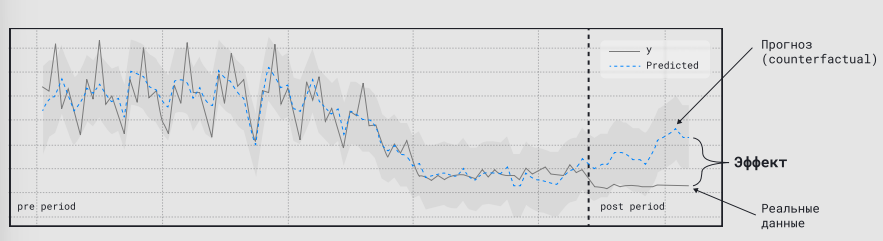

### Методы синтетического контроля:
* Существуют различные методы создания синтетического контроля, но одним из наиболее часто используемых подходов является ***Synthetic Control Method***
* SCM создает синтетическую контрольную группу, которая очень похожа на группу в которой есть изменения (test), и присваивает веса каждому значению в контрольной группе на основе того, насколько близко их характеристики до воздействия соответствуют характеристикам измененной группе
* Есть также другие методы, как например ***Difference-in-Differences Synthetic Control (DiD-SC)***. Это улучшенный метод SCM, который включает сравнение изменений результатов с течением времени

***Causal Impact*** - метод синтетического контроля, где мы используем модель временных рядов (в оригинальной статье bsts (Bayesian Structural Time-Series) модель) и дополнительные регрессоры (ковариаты) для построяния прогнозного, гипотетического поведения.

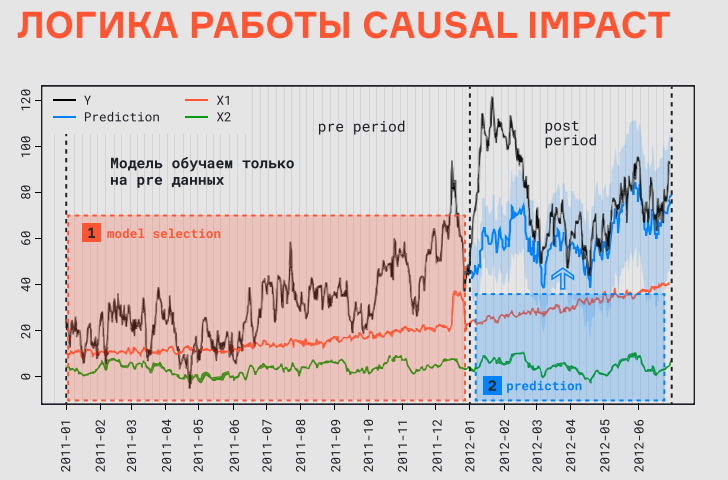

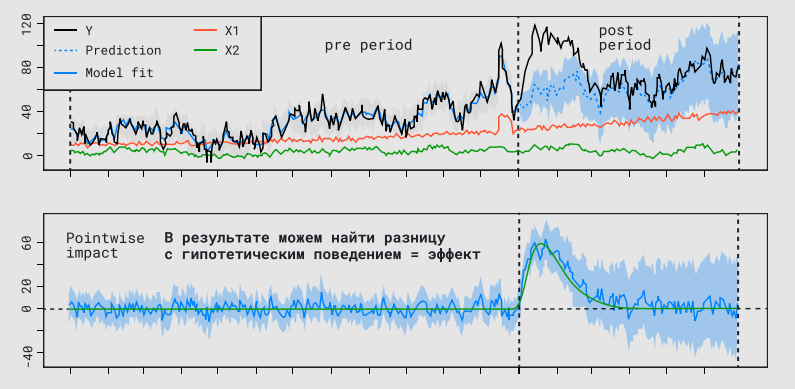

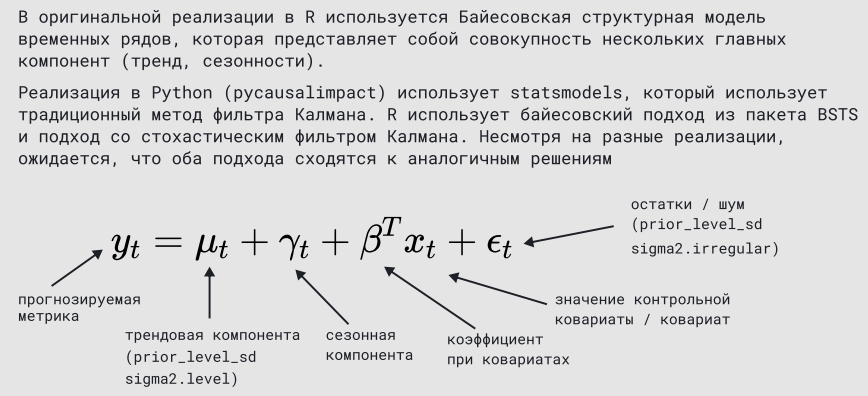

***Коварианта*** - любая переменная или предиктор, которая связана с зависимой переменной или переменной отклика, но может или не может быть контролируемой в исследовании.

Во многих случаях, если есть хорошая ковариата, которая по динамике схожа с динамикой основной метрики, то прогноз целевой метрики получается точнее, а доверительный интервал оценки эффекта уже.

В Causal Impact можно использовать несколько ковариат. Часто это значительно повышает качество прогноза.
Обычно простым методом подбора ковариат является поиск корреляции временных рядов целевой метрики и ковариаты.

***Требования к ковариатам:***
* ковариата должна быть коррелированна с исследуемым признаком (быть хорошим предиктором поведения в целевой метрике)
* при этом максимально очищена от влияния нововведения
* она должна представлять из себя также временной ряд (т.е. быть ориентирована во временном промежутке той же размерности)

Например: та же метрика в другом городе/категории/платформе, схожая метрика у конкурента, та же метрика с временным лагом, прокси метрики высокого порядка (но не близкие к целевой метрике), разные сегменты пользователей (если между ними нет миграции, т.е. группы независимые), прогноз метрики на pre-экспериментальных данных

***Как правильно подбирать ковариаты?***
- К подбору и генерации ковариат в целом подходят те же подходы, что и feture engineering моделей временного ряда
- Полезные техники: лаги основной метрики, агрегаты скользящего окна, математические преобразования (log, степени, box-cox и т.п.), комбинации из нескольких временных рядов, приросты и разницы метрик и т.п.)
- более правильно перебирать ковариаты по оценке мощности и стат. значимости теста. Для этого помогут методики симуляции и перебора. Особенно важно проводить симуляции на ваших реальных исторических данных, которые вы бы использовали в вашем конкретном эксперименте

Пример полученного результата

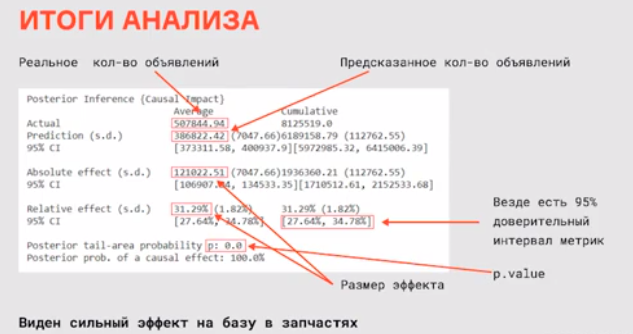

### Практика:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from itertools import combinations
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

# 1. Простой causal Impact

## 1.1. Causal Impact без эффекта

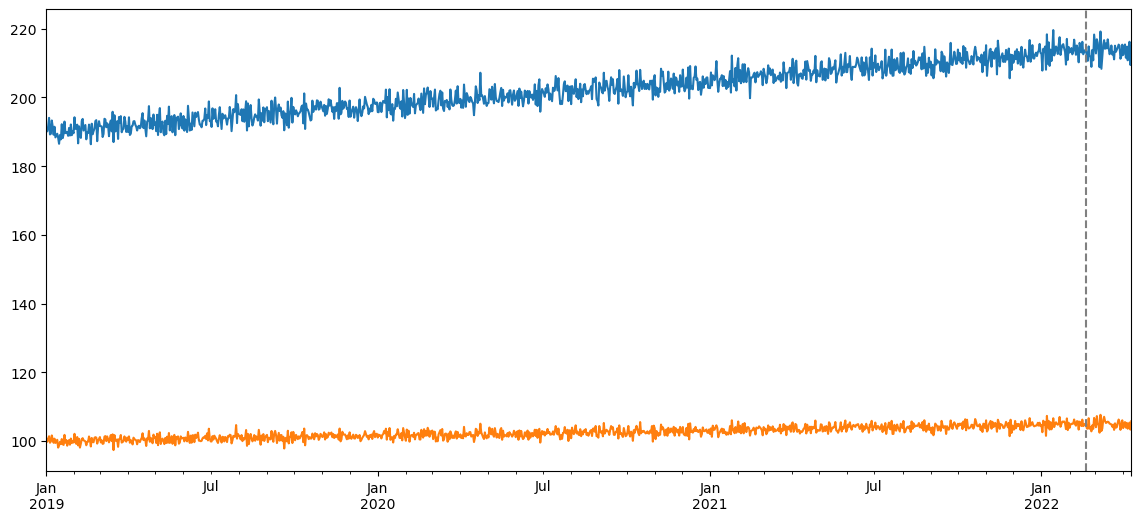

In [2]:
#Генерируем синтетические данные с помощью ARMA процесса, где y напрямую зависит от x

np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

trend_x0 = np.arange(0, 5, 5/1196) #добавим тренд
trend_y = np.arange(0, 15, 15/1196)

x0 = 100 + arma_process.generate_sample(nsample=1196) + trend_x0
y = 1.9 * x0 + np.random.normal(size=1196) + trend_y

data = pd.DataFrame({'x0': x0, 'y': y}, columns=['y', 'x0'])

date_range = pd.date_range(start="2019-01-01", periods=1196)
ts_data = data.copy()
ts_data.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2019-01-01", "2022-02-19"]]
ts_post_period = [pd.to_datetime(date) for date in ["2022-02-20", "2022-04-10"]]

ts_data.head()

plt.figure(figsize = (14, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
plt.axvline(x= '2022-02-19',  color = 'grey', ls = '--')

In [5]:
# проверим корреляцию рядов
ts_data.corr().style.background_gradient(cmap='coolwarm', axis=None)

<Axes: xlabel='x0', ylabel='y'>

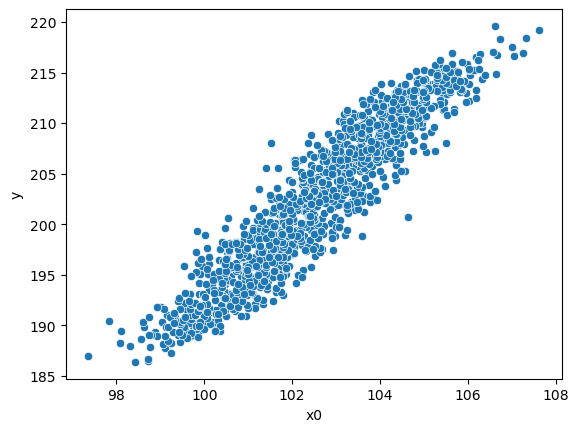

In [6]:
sns.scatterplot(x= ts_data.x0, y = ts_data.y)

Пример с ковариатой которая коррелирует на 0.89 (По ковариате остановимся детальнее чуть позже)

In [7]:
ts_data

y          x0
2019-01-01  190.924119  100.496714
2019-01-02  190.121521   99.766573
2019-01-03  191.585783  100.703571
2019-01-04  194.055172  101.396530
2019-01-05  189.236358   99.505771
...                ...         ...
2022-04-06  210.816741  103.580886
2022-04-07  214.696980  104.661552
2022-04-08  216.203636  105.371585
2022-04-09  209.440186  103.321820
2022-04-10  215.021437  105.770258

[1196 rows x 2 columns]

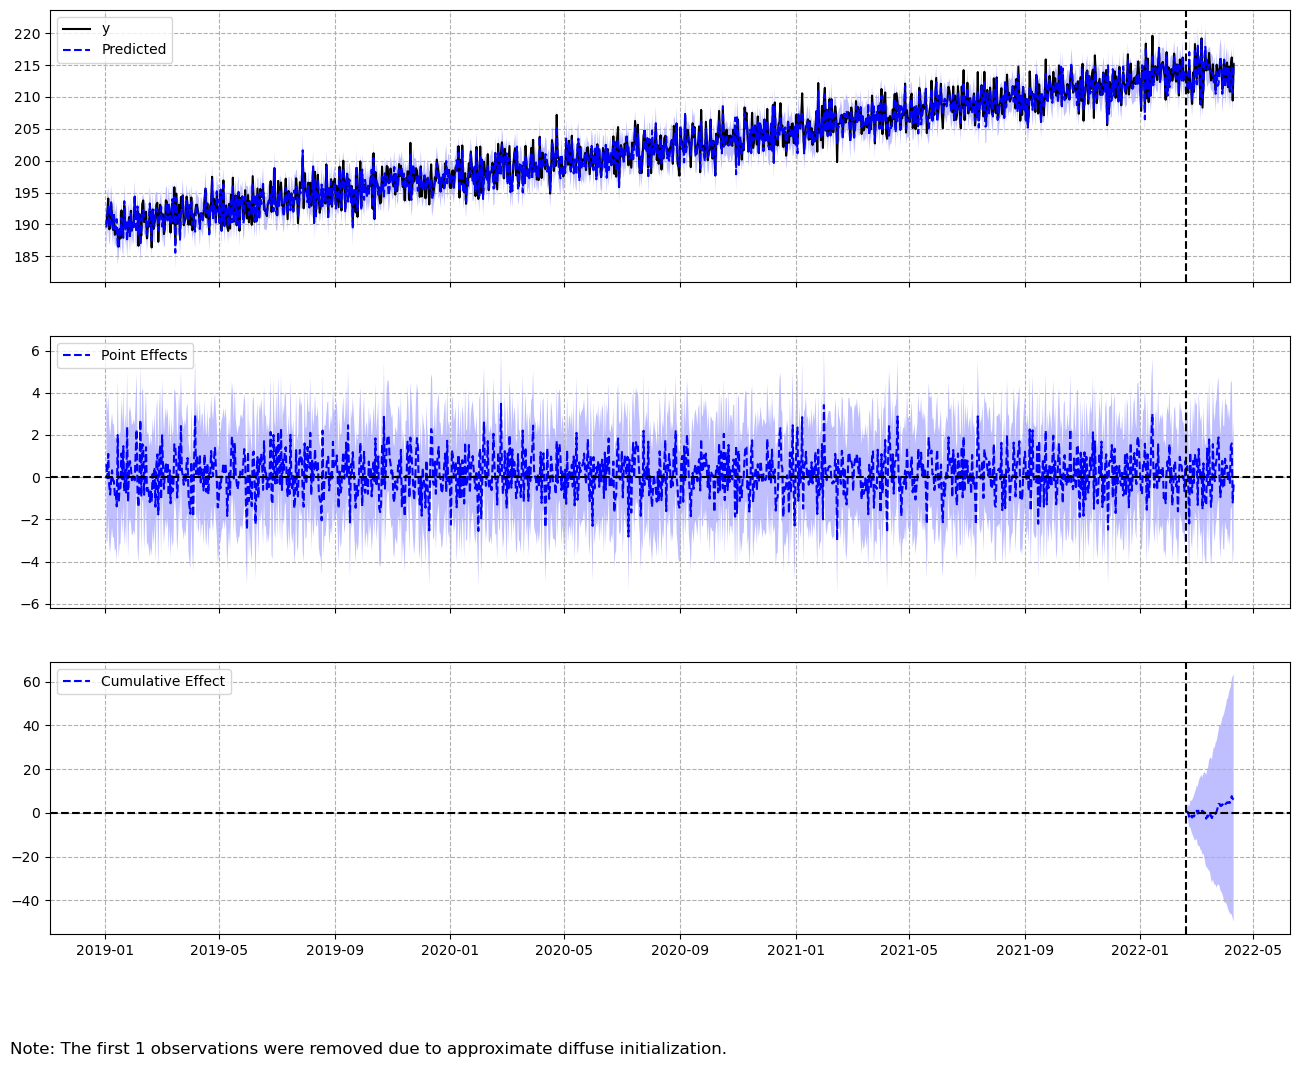

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    213.62             10681.21
Prediction (s.d.)         213.5 (0.44)       10675.15 (21.94)
99% CI                    [212.36, 214.62]   [10617.95, 10731.0]

Absolute effect (s.d.)    0.12 (0.44)        6.06 (21.94)
99% CI                    [-1.0, 1.27]       [-49.8, 63.25]

Relative effect (s.d.)    0.06% (0.21%)      0.06% (0.21%)
99% CI                    [-0.47%, 0.59%]    [-0.47%, 0.59%]

Posterior tail-area probability p: 0.39
Posterior prob. of a causal effect: 61.44%

For more details run the command: print(impact.summary('report'))


In [8]:
ci = CausalImpact(ts_data, ts_pre_period, ts_post_period, alpha = 0.01)
ci.plot(figsize = (16, 12))
print(ci.summary())

Мы не заложили эффект, что показывает и Causal Impact что изменение -0.09% с 99% доверительным интервалом [-0.45%, 0.26%] и с p-value = 0.26. При порверке гипотезы в Causal Impact, мы проверяем альтернативную гипотезу о том что есть разница против нулевой гипотезы что разницы между метрикой до изменении и после нет. В данном случае p-value = 0.26, мы не можем отвергнуть H0

## 1.2. Давайте попробуем симулировать эффект, добавим +3% с определённого периода

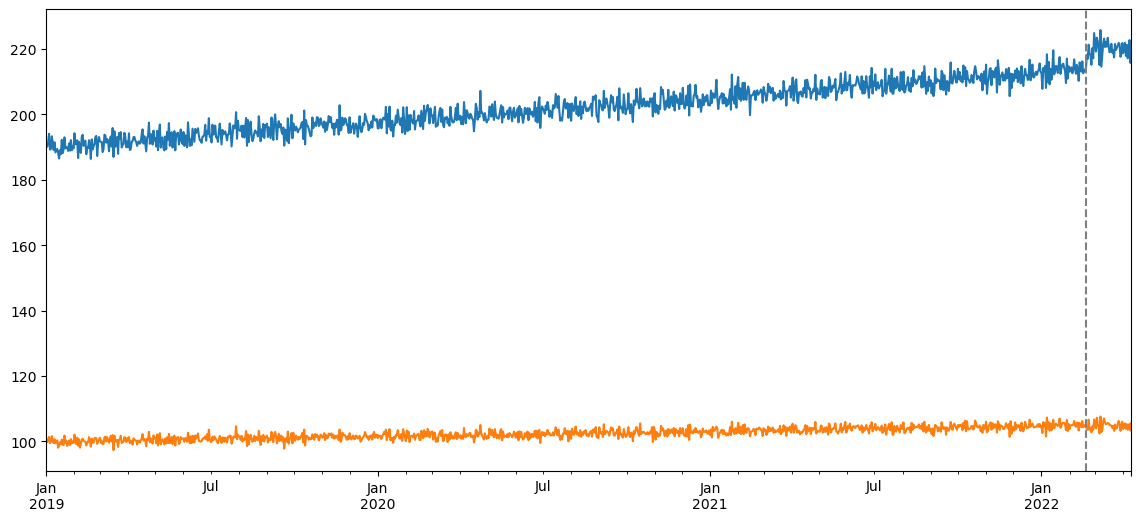

In [9]:
np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

trend_x0 = np.arange(0, 5, 5/1196) #добавим тренд
trend_y = np.arange(0, 15, 15/1196)

x0 = 100 + arma_process.generate_sample(nsample=1196) + trend_x0
y = 1.9 * x0 + np.random.normal(size=1196) + trend_y
data = pd.DataFrame({'x0': x0, 'y': y}, columns=['y', 'x0'])

date_range = pd.date_range(start="2019-01-01", periods=1196)
ts_data = data.copy()
ts_data.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2019-01-01", "2022-02-19"]]
ts_post_period = [pd.to_datetime(date) for date in ["2022-02-20", "2022-04-10"]]

ts_data.loc[ts_post_period[0]:ts_post_period[-1], 'y'] *= 1.03

plt.figure(figsize = (14, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
plt.axvline(x= '2022-02-19',  color = 'grey', ls = '--')

In [10]:
ts_data

y          x0
2019-01-01  190.924119  100.496714
2019-01-02  190.121521   99.766573
2019-01-03  191.585783  100.703571
2019-01-04  194.055172  101.396530
2019-01-05  189.236358   99.505771
...                ...         ...
2022-04-06  217.141243  103.580886
2022-04-07  221.137890  104.661552
2022-04-08  222.689745  105.371585
2022-04-09  215.723391  103.321820
2022-04-10  221.472081  105.770258

[1196 rows x 2 columns]

In [12]:
# посчитаем корреляцию 
ts_data.loc[:ts_pre_period[-1]].corr().style.background_gradient(cmap='coolwarm', axis=None)

<Axes: xlabel='x0', ylabel='y'>

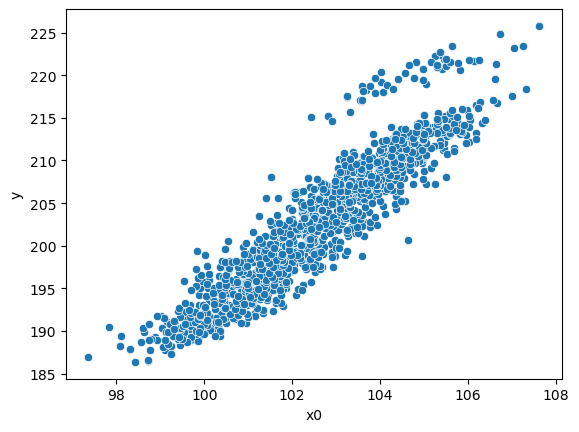

In [13]:
sns.scatterplot(x= ts_data.x0, y = ts_data.y)

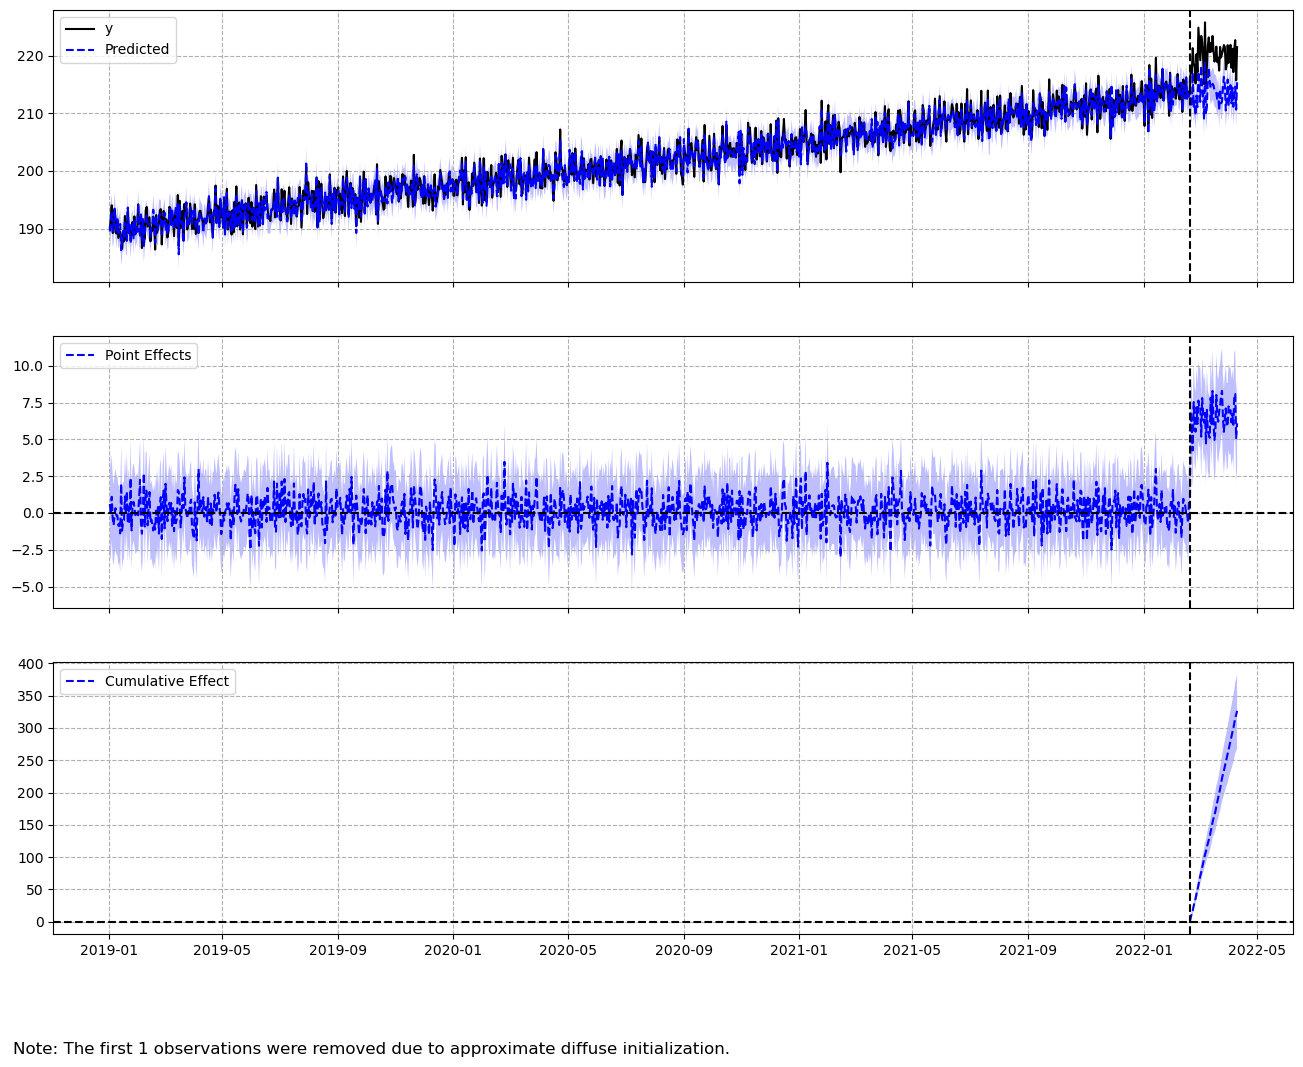

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    220.03             11001.64
Prediction (s.d.)         213.5 (0.45)       10675.15 (22.32)
99% CI                    [212.38, 214.68]   [10618.92, 10733.93]

Absolute effect (s.d.)    6.53 (0.45)        326.5 (22.32)
99% CI                    [5.35, 7.65]       [267.71, 382.72]

Relative effect (s.d.)    3.06% (0.21%)      3.06% (0.21%)
99% CI                    [2.51%, 3.59%]     [2.51%, 3.59%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [14]:
ci = CausalImpact(ts_data, ts_pre_period, ts_post_period, alpha = 0.01)
ci.plot(figsize = (16, 12))
print(ci.summary())

Видим, что в простом кейсе causal impact находит тот эффект, который мы закладывали. При этом даже не с паралельными трендами

## 1.3. Обращение к summary модели

In [15]:
# можно обратится к summary s виде таблицы
ci.summary_data

average    cumulative
actual            220.032844  11001.642176
predicted         213.502914  10675.145704
predicted_lower   212.378460  10618.922994
predicted_upper   214.678584  10733.929213
abs_effect          6.529929    326.496472
abs_effect_lower    5.354259    267.712963
abs_effect_upper    7.654384    382.719182
rel_effect          0.030585      0.030585
rel_effect_lower    0.025078      0.025078
rel_effect_upper    0.035851      0.035851

In [16]:
#С помощью этого метода можно вызвать общую информацию по регрессионной модели, включая коэффициенты параметров моделей, их стат. значимость, критерий Акаике, Льюнга-Бокса и т.д.
# sigma2.irregular - шум
# sigma2.level - тренд
# beta.x - коэффициент при регрессорах
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                 1146
Model:                    local level   Log Likelihood                 613.712
Date:                Mon, 23 Oct 2023   AIC                          -1221.425
Time:                        13:13:25   BIC                          -1206.295
Sample:                    01-01-2019   HQIC                         -1215.712
                         - 02-19-2022                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0184      0.001     22.617      0.000       0.017       0.020
sigma2.level         0.0001   4.03e-05      3.187      0.001    4.94e-05       0.000
beta.x0              0.4705      0.007     67.767      0.000       0.457       0.484
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.24   Prob(JB):                         0.81
Heteroskedasticity (H):               0.93   Skew:                             0.04
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Так как эта модель является регрессионной моделью "local level", и имеет критерий Акаике которая определяется следующей формулой:

<center>$\large AIC = -2\ln L + 2k$
    
где $L$ $-$ правдоподобие, $k$ - число параметров в модели
    
Можно пытаться подбирать ковариаты или в целом модель таким образом, чтобы минимизировать этот критерий

Так же отдельно от общей информации по регрессионной модели, можно отдельно вывести значения Z - статистики (так же можно и T - статистики) по параметрам модели, а так же их p-value значения для проверки на стат. значимость. И доверительные интервалы как нижние, так и верхние

In [17]:
# можно обращаться к элементам summary по модели

ci.trained_model.zvalues

sigma2.irregular    22.617323
sigma2.level         3.187005
beta.x0             67.767339
dtype: float64

In [18]:
# проверка коэффициентов модели на стат значимость
ci.trained_model.pvalues > 0.01

sigma2.irregular    False
sigma2.level        False
beta.x0             False
dtype: bool

In [19]:
# доверительные интервалы для коэффициентов модели
ci.trained_model.conf_int()

0         1
sigma2.irregular  0.016811  0.020001
sigma2.level      0.000049  0.000207
beta.x0           0.456923  0.484140

In [20]:
# Этим методом можно посмотреть на предсказанные значения, их доверительные интервалы, разницу между факт. и предсказанными значениями, и т.д.
ci.inferences

post_cum_y       preds  post_preds  post_preds_lower  \
2019-01-01           NaN  198.099378         NaN               NaN   
2019-01-02           NaN  189.512419         NaN               NaN   
2019-01-03           NaN  191.629679         NaN               NaN   
2019-01-04           NaN  192.954688         NaN               NaN   
2019-01-05           NaN  189.580738         NaN               NaN   
...                  ...         ...         ...               ...   
2022-04-06  10120.619069  211.143036  211.143036        208.168120   
2022-04-07  10341.756959  213.232466  213.232466        210.250157   
2022-04-08  10564.446704  214.605289  214.605289        211.615606   
2022-04-09  10780.170096  210.642142  210.642142        207.645104   
2022-04-10  11001.642176  215.376108  215.376108        212.371732   

            post_preds_upper   preds_lower   preds_upper  post_cum_pred  \
2019-01-01               NaN -18329.860192  18726.058949            NaN   
2019-01-02               NaN    185.951364    193.073473            NaN   
2019-01-03               NaN    188.542153    194.717204            NaN   
2019-01-04               NaN    190.040403    195.868973            NaN   
2019-01-05               NaN    186.755789    192.405688            NaN   
...                      ...           ...           ...            ...   
2022-04-06        214.117953    208.168120    214.117953    9821.289700   
2022-04-07        216.214774    210.250157    216.214774   10034.522166   
2022-04-08        217.594971    211.615606    217.594971   10249.127454   
2022-04-09        213.639180    207.645104    213.639180   10459.769596   
2022-04-10        218.380484    212.371732    218.380484   10675.145704   

            post_cum_pred_lower  post_cum_pred_upper  point_effects  \
2019-01-01                  NaN                  NaN      -7.175259   
2019-01-02                  NaN                  NaN       0.609102   
2019-01-03                  NaN                  NaN      -0.043896   
2019-01-04                  NaN                  NaN       1.100484   
2019-01-05                  NaN                  NaN      -0.344381   
...                         ...                  ...            ...   
2022-04-06          9770.116577          9873.740104       5.998206   
2022-04-07          9982.171857         10088.556048       7.905424   
2022-04-08         10194.049997         10303.844418       8.084456   
2022-04-09         10404.405471         10516.010605       5.081250   
2022-04-10         10618.922994         10733.929213       6.095973   

            point_effects_lower  point_effects_upper  post_cum_effects  \
2019-01-01        -18535.134829         18520.784311               NaN   
2019-01-02            -2.951952             4.170157               NaN   
2019-01-03            -3.131421             3.043630               NaN   
2019-01-04            -1.813801             4.014770               NaN   
2019-01-05            -3.169331             2.480569               NaN   
...                         ...                  ...               ...   
2022-04-06             3.023290             8.973123        299.329369   
2022-04-07             4.923115            10.887733        307.234793   
2022-04-08             5.094774            11.074139        315.319250   
2022-04-09             2.084212             8.078288        320.400499   
2022-04-10             3.091597             9.100349        326.496472   

            post_cum_effects_lower  post_cum_effects_upper  
2019-01-01                     NaN                     NaN  
2019-01-02                     NaN                     NaN  
2019-01-03                     NaN                     NaN  
2019-01-04                     NaN                     NaN  
2019-01-05                     NaN                     NaN  
...                            ...                     ...  
2022-04-06              246.878965              350.502492  
2022-04-07              253.200911        

## 1.4. Оценка качества прогноза модели

На уже существующих данных, можно попробовать оценить:
- MAE (Mean Absolute Error - Средняя Абсолютная Ошибка)
- MAPE
- R2_score

In [21]:
# Метрики оценки на зафиттенных данных
ci_data = ci.data.merge(ci.inferences, left_index = True, right_index = True)
ci_data_pre = ci_data.loc[ts_pre_period[0]:ts_pre_period[-1], :]

mae = mean_absolute_error(ci_data_pre.y, ci_data_pre.preds)
mape = mean_absolute_percentage_error(ci_data_pre.y, ci_data_pre.preds)
r2 = r2_score(ci_data_pre.y, ci_data_pre.preds)

print('MAE =', round(mae, 3))
#print('MAE =', round(ci_data_pre.point_effects.abs().mean(), 3))
print('MAPE =', round(mape, 3))
print('R2_score =', r2)

MAE = 0.814
MAPE = 0.004
R2_score = 0.9791258278913856


В Causal Impact уже есть метод вызова MAE, но здесь он считает по данным после нормирования (перед предсказаниями Causal Impact нормирует данные)

В этом можно убедиться сравнив MAE с метода и с подсчётом с нормированных данных

In [22]:
print(ci.trained_model.mae)
print(mean_absolute_error(ci.normed_pre_data.y, ci.trained_model.fittedvalues))

0.1131303470879454
0.1131303470879454


## 1.5. Анализа остатков модели

http://www.machinelearning.ru/wiki/index.php?title=%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D0%BE%D1%81%D1%82%D0%B0%D1%82%D0%BA%D0%BE%D0%B2#.D0.A1.D0.B2.D0.BE.D0.B9.D1.81.D1.82.D0.B2.D0.B0_.D1.80.D0.B5.D0.B3.D1.80.D0.B5.D1.81.D1.81.D0.B8.D0.BE.D0.BD.D0.BD.D1.8B.D1.85_.D0.BE.D1.81.D1.82.D0.B0.D1.82.D0.BA.D0.BE.D0.B2

#### Хорошая модель если: 
* Остатки стационарны
* Несмещенность остатков . Мат ожидание остатков = 0
* Неавтокоррелированность остатков. Автокоррелция - это корреляция, проявляющаяся во времени.

**Для проверки этих предположений в causal impact встроены несколько стат критериев**

#### Статистический критерий Дики-Фуллера. Проверка на стационарность
https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0

$\large H_0:$ ряд нестационарен

$\large H_1:$ ряд стационарен

#### Тест Стьюдента (Одновыборочный t - критерий). Проверка на несмещенность остатков относительно 0
$\large H_0: \bar{x} = m$

$\large H_1: \bar{x} \neq m$

Несмещённость - равенство среднего значения нуля

#### Критерий Льюнга-Бокса. Проверка на наличие автокорреляции
https://einsteins.ru/subjects/ekonometrika/teoriya-ekonometrika/ponyatie-i-prichiny-avtokorrelyacii
http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%9B%D1%8C%D1%8E%D0%BD%D0%B3%D0%B0-%D0%91%D0%BE%D0%BA%D1%81%D0%B0

$\large H_0:$ остатки неавтокоррелированы

$\large H_1:$ остатки автокоррелированы (underfit)

p-value тест Дики-Фуллера = 0.000000
p-value тест Стьюдента = 0.000002
p-value тест Льюнга-Бокса = 0.241498


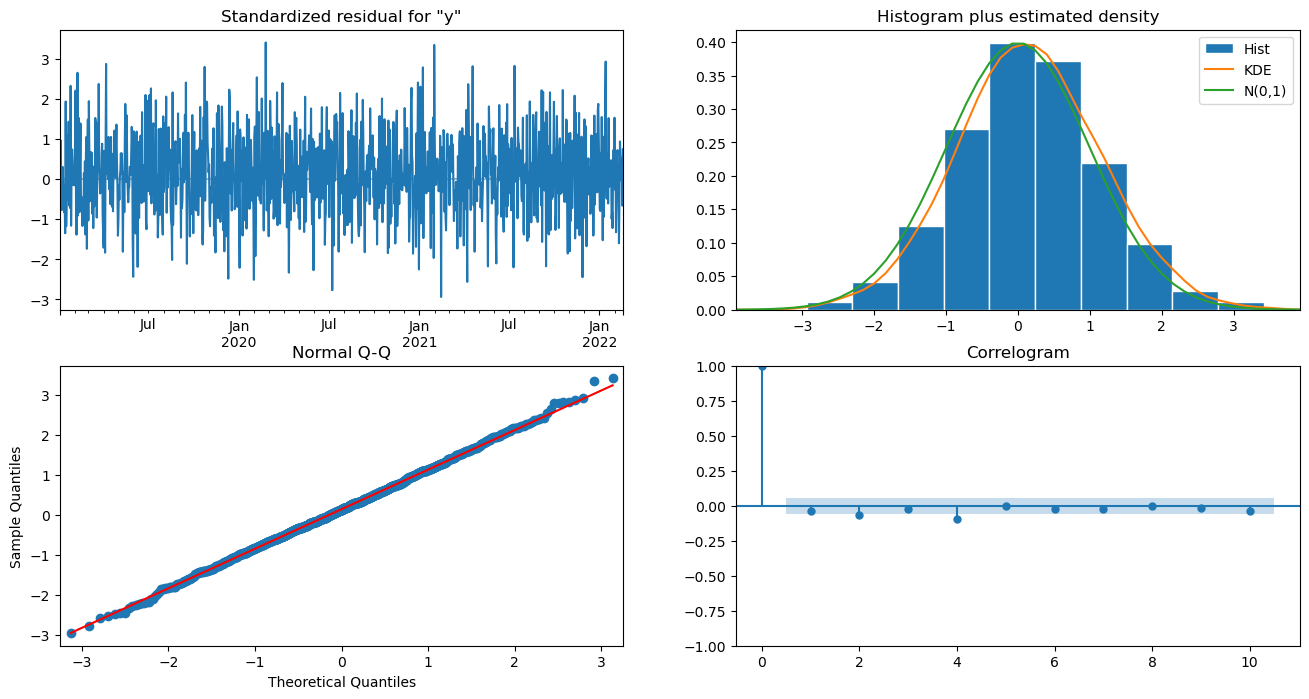

In [23]:
# давайте отпринтуем результаты проверки остатков модели
print("p-value тест Дики-Фуллера = %f" % sm.tsa.stattools.adfuller(ci.trained_model.resid)[1])
print("p-value тест Стьюдента = %f" % ttest_1samp(ci.trained_model.resid, 0)[1])
print("p-value тест Льюнга-Бокса = %f" % ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci.trained_model.plot_diagnostics(figsize = (16, 8));

По стат. критерию Дики-Фуллера а так же по графику стандартизированного распределения остатков, можно увидеть что остатки стационарны.

По стат. критерию Стьюдента а так же по графику гистограммы распределения остатков, можем наблюдать что остатки несмещены и ср. значение находится близко к нулю.

По стат. критерию Q-критерия Льюнга-Бокса а так же по графику Q-Q и коррелограммы, видно что остатки неавтокоррелированы.

# 2. Causal impact на реальных данных
## Кейс с ценами на запчасти

### 2.1 Выгружаем данные

In [24]:
spares_data = pd.read_csv('ci_spares_data.csv', index_col = 'date', parse_dates = True)
spares_data

cnt_adverts_spare  cnt_users_spare  revenue_spare  \
date                                                            
2020-02-02             211754             8650        1488315   
2020-02-03             212954             8728        2409055   
2020-02-04             210585             8697        2369018   
2020-02-05             209464             8718        3368615   
2020-02-06             207544             8738        2123040   
...                       ...              ...            ...   
2020-05-12             243824             9927         506893   
2020-05-13             251088             9998         587750   
2020-05-14             252553            10108         558680   
2020-05-15             257058            10125         510576   
2020-05-16             256684            10131         508986   

            cnt_adverts_cars  cnt_users_cars  revenue_cars  holidays  \
date                                                                   
2020-02-02            208126          127603       6715565         0   
2020-02-03            212119          129672       7659757         0   
2020-02-04            209994          129373       7647455         0   
2020-02-05            209486          129736       7654975         0   
2020-02-06            209644          129867       7877610         0   
...                      ...             ...           ...       ...   
2020-05-12            154158           96834       4069322         0   
2020-05-13            157206           98852       4228780         0   
2020-05-14            160448          100813       4515470         0   
2020-05-15            162323          102421       4043315         0   
2020-05-16            164362          103873       4043712         0   

            new_users_share_spare  new_users_share_auto  
date                                                     
2020-02-02                 0.1183               0.15925  
2020-02-03                 0.1313               0.17675  
2020-02-04                 0.1339               0.18025  
2020-02-05                 0.1196               0.16100  
2020-02-06                 0.1248               0.16800  
...                           ...                   ...  
2020-05-12                 0.1183               0.15925  
2020-05-13                 0.1170               0.15750  
2020-05-14                 0.1261               0.16975  
2020-05-15                 0.1326               0.17850  
2020-05-16                 0.1170               0.15750  

[105 rows x 9 columns]

In [25]:
# создадим индекс в виде дат
spares_data.index = pd.to_datetime(spares_data.index) 

In [26]:
spares_data.head()

cnt_adverts_spare  cnt_users_spare  revenue_spare  \
date                                                            
2020-02-02             211754             8650        1488315   
2020-02-03             212954             8728        2409055   
2020-02-04             210585             8697        2369018   
2020-02-05             209464             8718        3368615   
2020-02-06             207544             8738        2123040   

            cnt_adverts_cars  cnt_users_cars  revenue_cars  holidays  \
date                                                                   
2020-02-02            208126          127603       6715565         0   
2020-02-03            212119          129672       7659757         0   
2020-02-04            209994          129373       7647455         0   
2020-02-05            209486          129736       7654975         0   
2020-02-06            209644          129867       7877610         0   

            new_users_share_spare  new_users_share_auto  
date                                                     
2020-02-02                 0.1183               0.15925  
2020-02-03                 0.1313               0.17675  
2020-02-04                 0.1339               0.18025  
2020-02-05                 0.1196               0.16100  
2020-02-06                 0.1248               0.16800

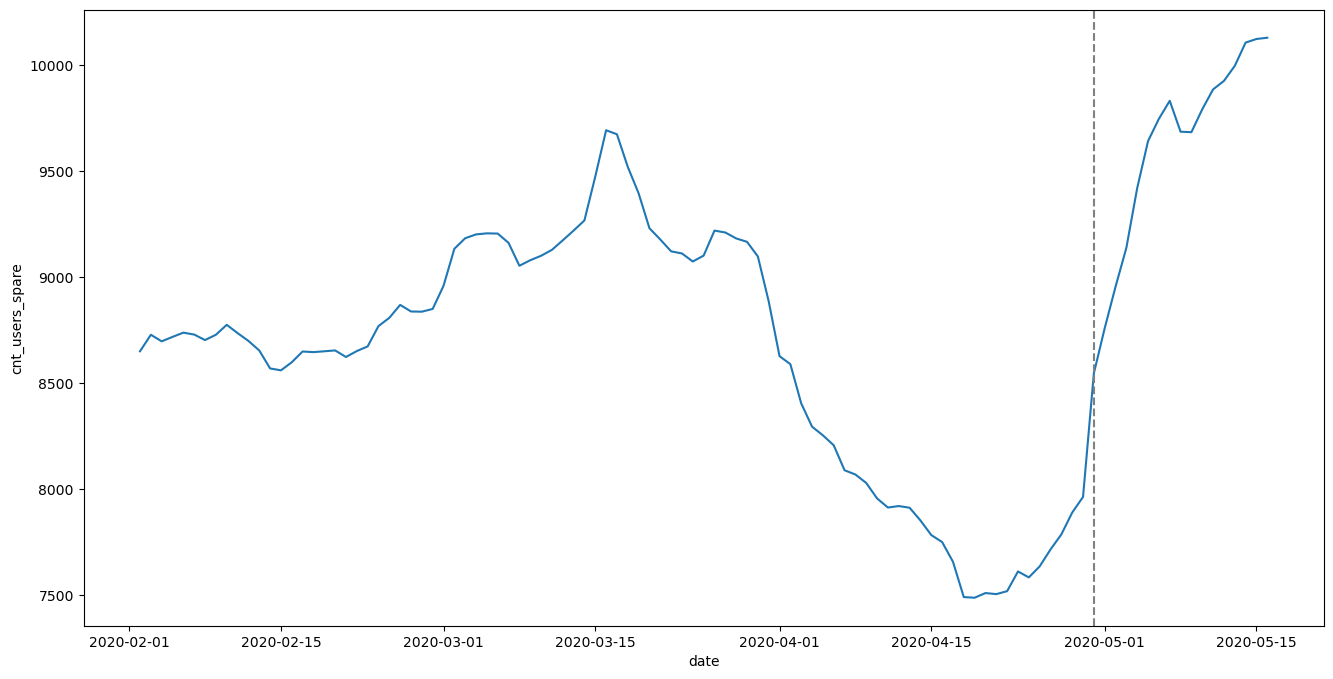

In [27]:
plt.figure(figsize = (16, 8))
sns.lineplot(data = spares_data, x = spares_data.index, y = 'cnt_users_spare')
plt.axvline(x= pd.to_datetime('2020-04-30'), color = 'gray', ls = '--')

### 2.2. Проверим эффект на кол-во пользователей в запчастях

#### Определим ковариаты

In [28]:
spares_data.corr().style.background_gradient(cmap='coolwarm', axis=None)

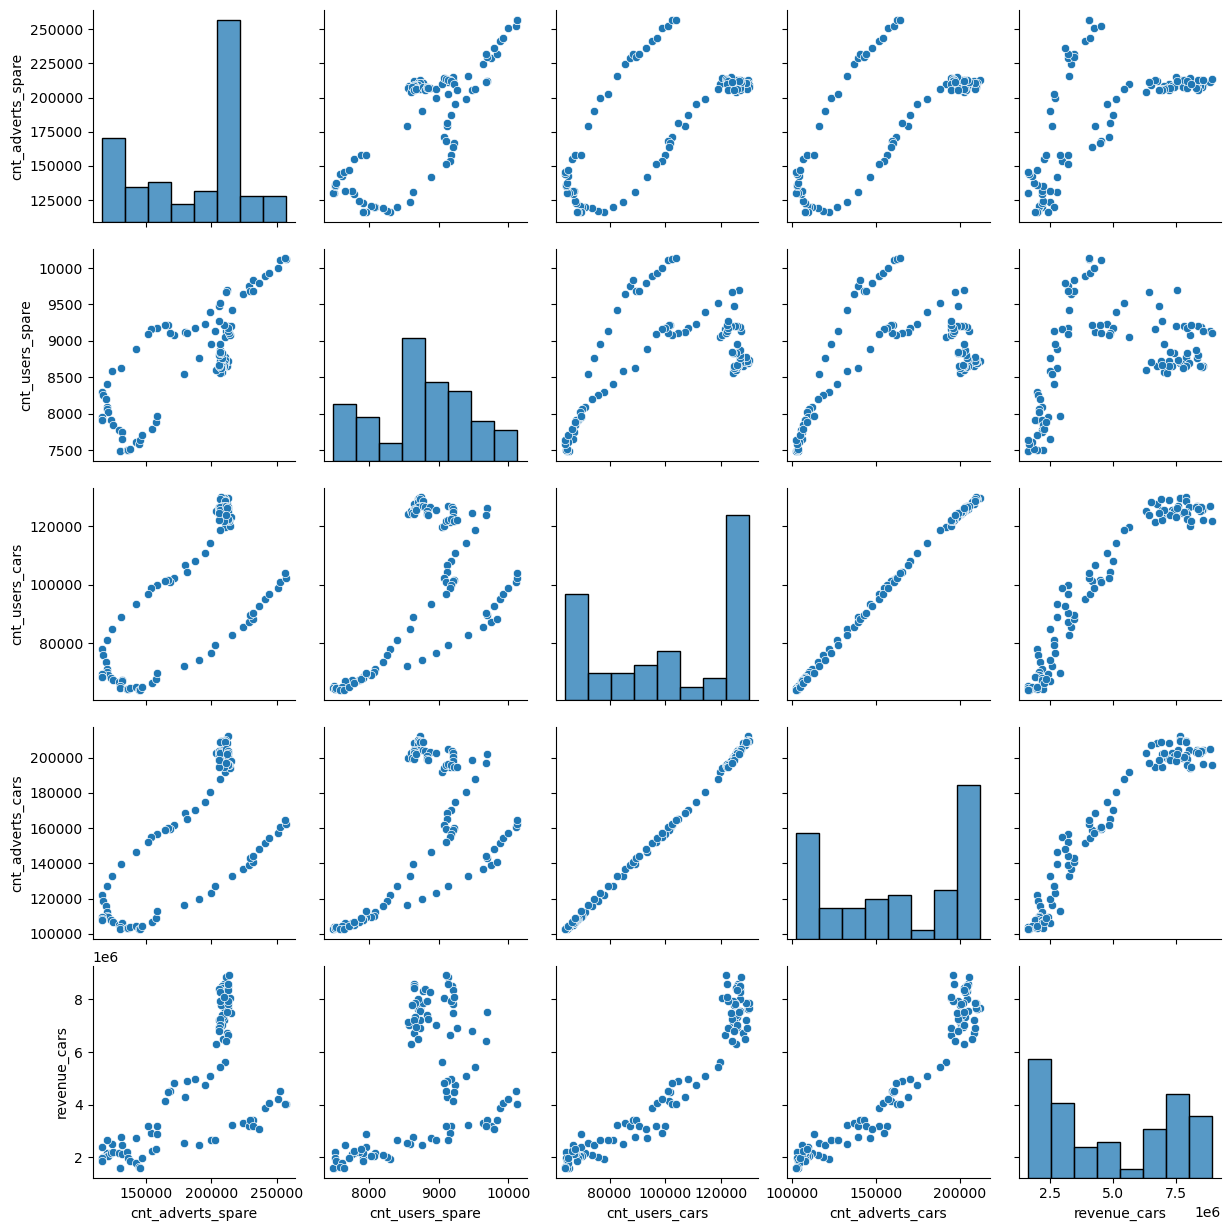

In [29]:
#определим ковариаты
sns.pairplot(spares_data[['cnt_adverts_spare', 'cnt_users_spare', 'cnt_users_cars', 'cnt_adverts_cars', 'revenue_cars']])

Из здравого смысла и по уровню корреляции можно выделить следующие ковариаты для метрики кол-во пользователей в катеории запчасти (cnt_users_spare):
- cnt_adverts_cars
- cnt_users_cars
- new_users_share_auto
- revenue_cars

Их и будем использовать в модели

In [30]:
# создадим датасет для СI
data_1 = spares_data.loc[:,['cnt_users_spare', 'cnt_users_cars', 'cnt_adverts_cars', 'new_users_share_auto', 'revenue_cars']]
pre_period = ['2020-02-02', '2020-04-29'] # если индекс в данных не временной - можно просто передавать порядковый номер строки с которой начинается intervention
post_period = ['2020-04-30', '2020-05-16']
data_1.head()

cnt_users_spare  cnt_users_cars  cnt_adverts_cars  \
date                                                            
2020-02-02             8650          127603            208126   
2020-02-03             8728          129672            212119   
2020-02-04             8697          129373            209994   
2020-02-05             8718          129736            209486   
2020-02-06             8738          129867            209644   

            new_users_share_auto  revenue_cars  
date                                            
2020-02-02               0.15925       6715565  
2020-02-03               0.17675       7659757  
2020-02-04               0.18025       7647455  
2020-02-05               0.16100       7654975  
2020-02-06               0.16800       7877610

In [31]:
# обучим модель
ci_1 = CausalImpact(data_1, pre_period, post_period)

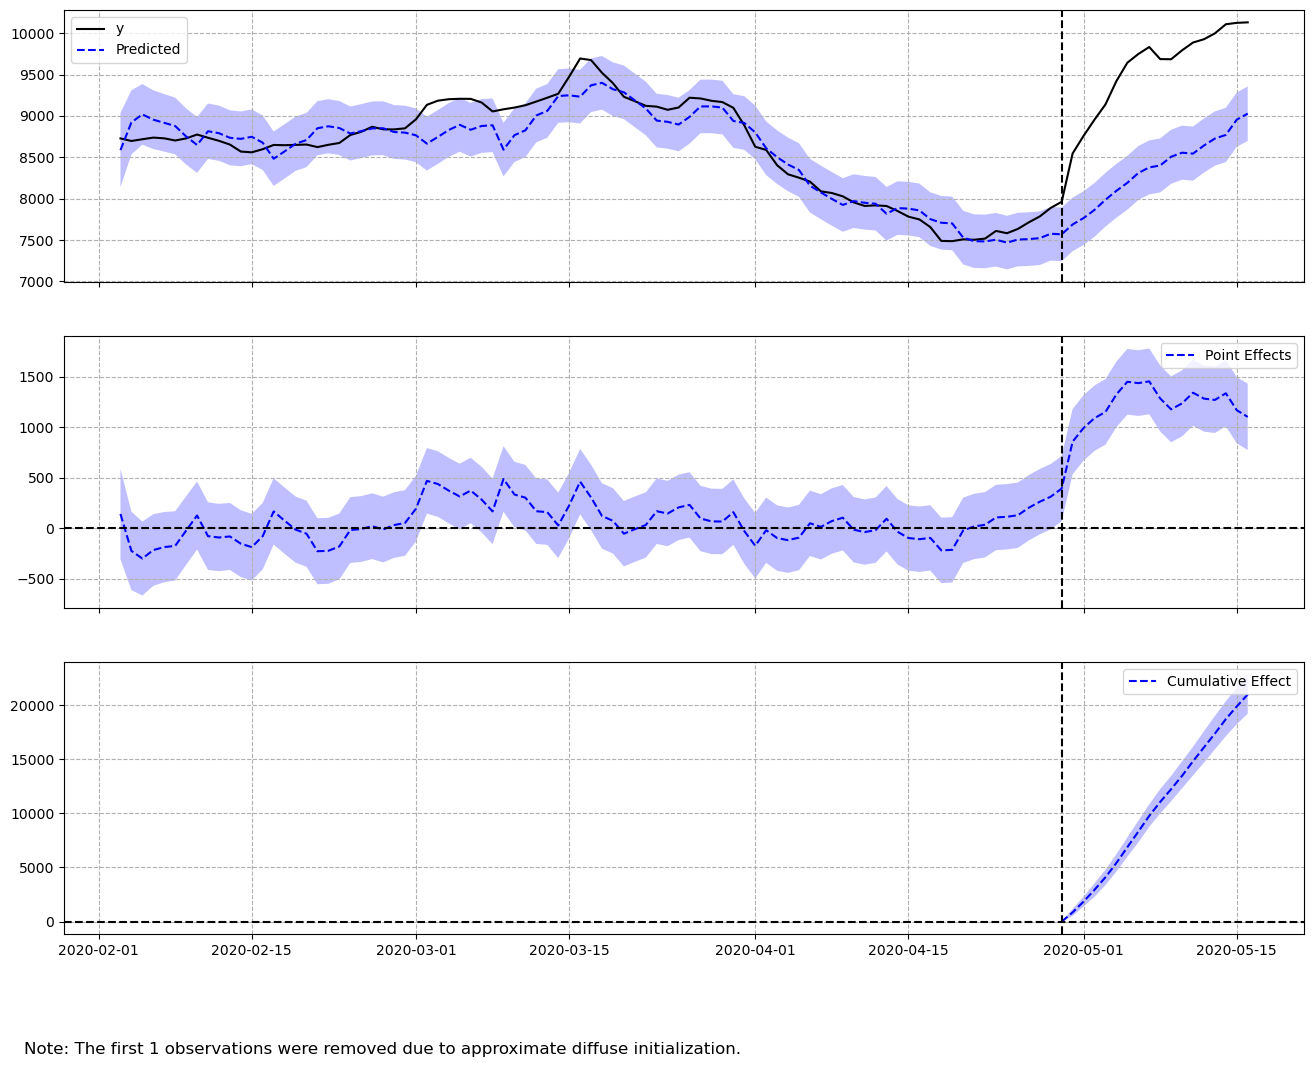

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    9610.88            163385.0
Prediction (s.d.)         8376.85 (54.19)    142406.41 (921.23)
95% CI                    [8268.9, 8481.32]  [140571.32, 144182.48]

Absolute effect (s.d.)    1234.03 (54.19)    20978.59 (921.23)
95% CI                    [1129.56, 1341.98] [19202.52, 22813.68]

Relative effect (s.d.)    14.73% (0.65%)     14.73% (0.65%)
95% CI                    [13.48%, 16.02%]   [13.48%, 16.02%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [32]:
# посмотрим результаты
ci_1.plot(figsize = (16, 12))
print(ci_1.summary())

In [33]:
ci_1.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:        cnt_users_spare   No. Observations:                   88
Model:                    local level   Log Likelihood                 -27.846
Date:                Mon, 23 Oct 2023   AIC                             67.691
Time:                        13:20:07   BIC                             82.486
Sample:                    02-02-2020   HQIC                            73.649
                         - 04-29-2020                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
sigma2.irregular              0.0763      0.015      5.098      0.000       0.047       0.106
sigma2.level                  0.0001      0.000      0.976      0.329      -0.000       0.000
beta.cnt_users_cars          12.6552      1.390      9.103      0.000       9.931      15.380
beta.cnt_adverts_cars       -11.6417      1.492     -7.802      0.000     -14.566      -8.717
beta.new_users_share_auto     0.0318      0.039      0.815      0.415      -0.045       0.108
beta.revenue_cars            -0.1347      0.120     -1.125      0.261      -0.369       0.100
===================================================================================
Ljung-Box (L1) (Q):                  55.61   Jarque-Bera (JB):                 3.54
Prob(Q):                              0.00   Prob(JB):                         0.17
Heteroskedasticity (H):               0.84   Skew:                             0.46
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p-value тест Дики-Фуллера = 0.157887
p-value тест Стьюдента = 0.004613
p-value тест Льюнга-Бокса = 0.000000


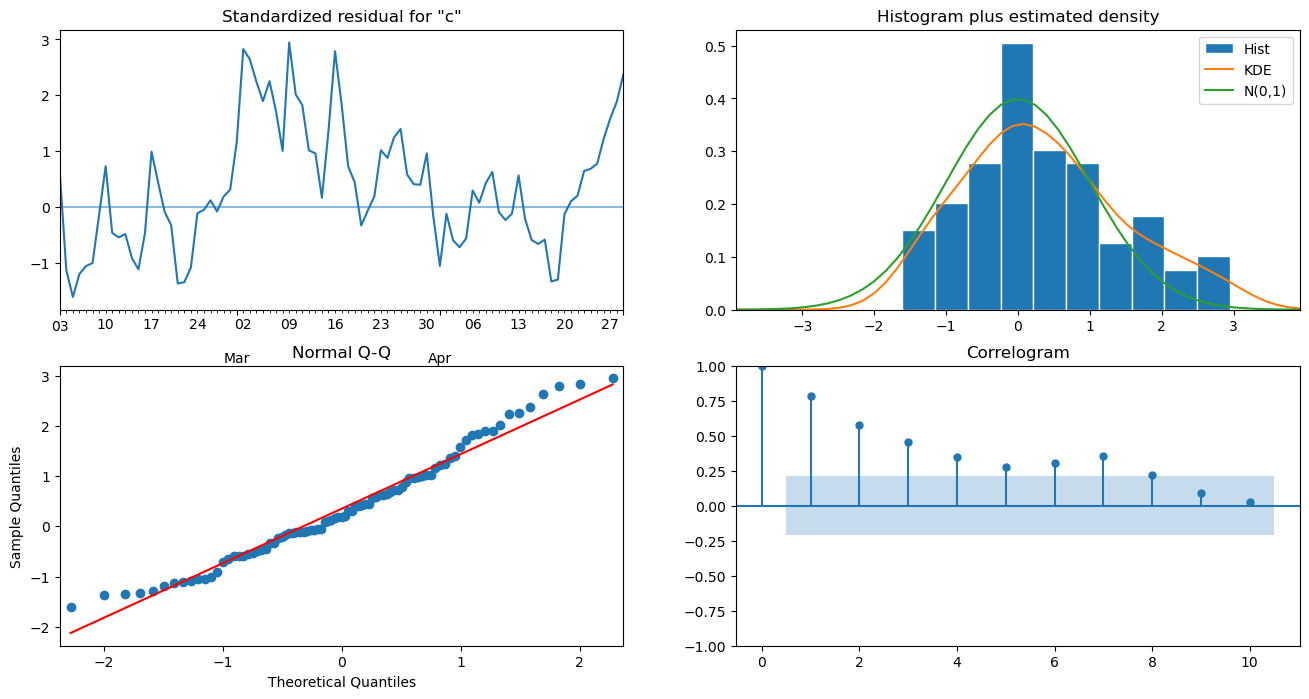

In [34]:
# давайте отпринтуем результаты проверки остатков модели
print("p-value тест Дики-Фуллера = %f" % sm.tsa.stattools.adfuller(ci_1.trained_model.resid)[1])
print("p-value тест Стьюдента = %f" % ttest_1samp(ci_1.trained_model.resid, 0)[1])
print("p-value тест Льюнга-Бокса = %f" % ci_1.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci_1.trained_model.plot_diagnostics(figsize = (16, 8));

# 3. Методология подбора ковариат на основе искусственных эффектов на имеющихся данных

https://www.oncrawl.com/technical-seo/quality-causalimpact-predictions/ (Jean-Christophe Chouinard, Evaluating The Quality Of CausalImpact Predictions (15 Feb, 2022)) 

Иногда могут быть несколько очень схожих метрик в похожих сегментах, т.е. потенциальных ковариат может быть несколько. Как выбрать наилучшие комбинации ковариат?

## 3.1. объяснение схемы симуляции

### одна итерация
- выберем какую то ковариату (control A)
- выберем какой-то период
- начиная с того периода создадим искусственные эффекты и сравниваем prediction с реальным эффектом
- находим какую-нибудь меру ошибки (например sse)

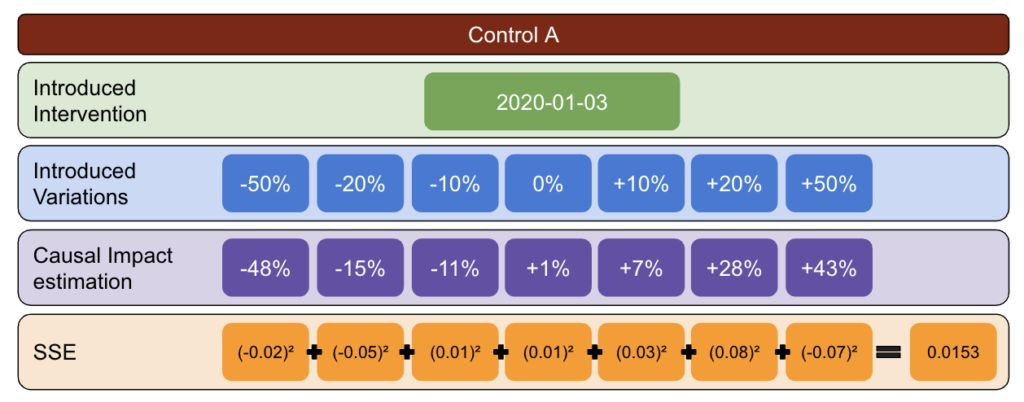

### 2 - Повторяем итерацию для разных дат многократно

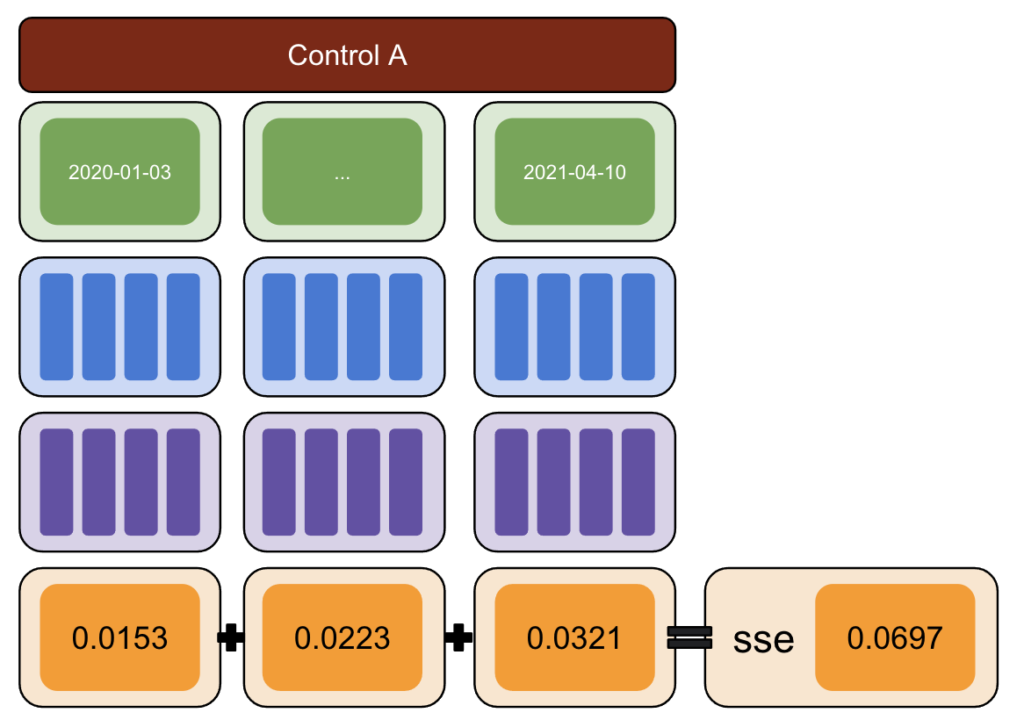

### 3 - Повторяем симуляцию для разных ковариат (control A-Z). Перебираем разные ковариаты

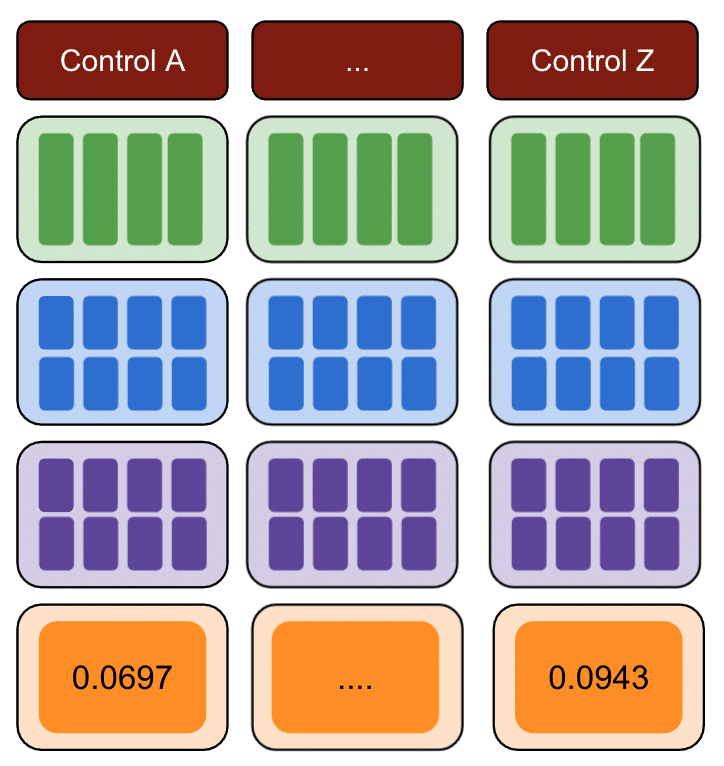

### Итоговая таблица с ошибками той или иной ковариаты, где можем отсортировать по наименьшей ошибке и выбрать подходящую ковариату

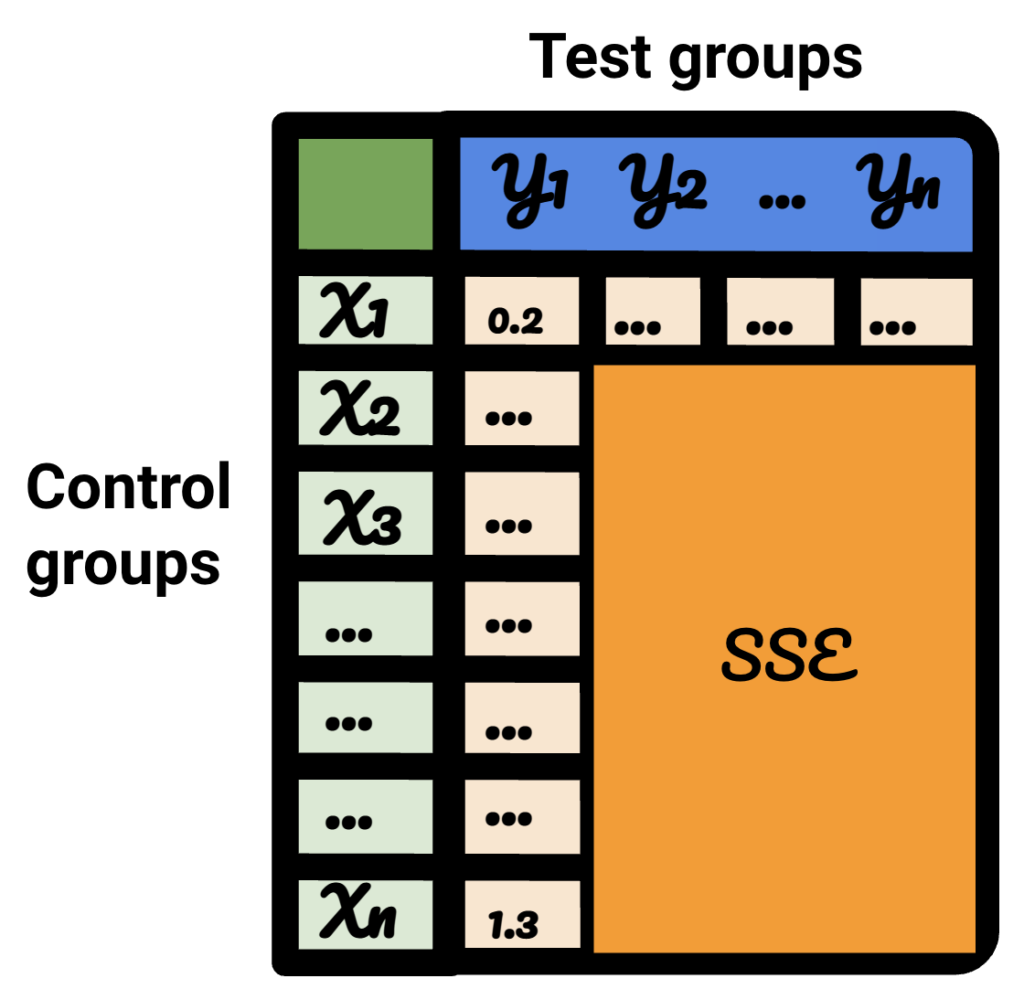


## 3.2. Напишем функцию для симуляции

In [35]:
import joblib

def causal_analysis(data, target_value, covariate, n_days = 14, control_percent = 0.6, sample_n = 30):
    '''
    data - исторические данные на которых мы оцениваем ковариату
    covariate - назвние столбца ковариат
    n_days - период в днях на post период
    control_percent - доля датасета зарезервированного под pre период (0.1)
    sample_n - кол-во симуляций
    
    '''
    n_days -= 1
    
    data = pd.concat([data.loc[:, [target_value]], data.loc[:, covariate]], axis = 1)
    
    df_copy = data.copy()
    effects = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1] # Эффекты
    rel_effects = []

    #dates = pd.DataFrame(data.index, columns = ['post_period_0']) # Даты
    dates = pd.DataFrame({'post_period_0': data.index}) # Даты

    # Самая первая дата контрольной группы
    initial = dates.values[0][0]
    # Тестовая группа, подбираем из неё 10 рандомных дат
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\
    # Определяем пост и пре период
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            df_copy = data.copy() # создаём другую переменную дубликата датафрейма чтобы каждый раз задавать новый эффект

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), target_value] *= effects[i] # задаём эффект
            ci = CausalImpact(df_copy, pre_period, post_period)

            relative_eff = ci.summary_data.loc['rel_effect', :][0].round(3)
            real_eff = effects[i] - 1
            to_sse = pow(relative_eff - real_eff, 2)
            to_mape = abs(relative_eff - real_eff) * 100

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(relative_eff)
            p_vals.append(ci.p_value)
        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1)], p_vals[effects.index(1.025)], 
               p_vals[effects.index(0.975)], p_vals[effects.index(1.05)], p_vals[effects.index(0.95)],
               p_vals[effects.index(1.1)], p_vals[effects.index(0.9)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))
    
    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]
        
    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_025', 'p_val_0_975',
                                    'p_val_1_05', 'p_val_0_95', 'p_val_1_1', 'p_val_0_9'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['covariate'] = ', '.join(covariate)
    return final

## 3.3. Прогоним методику симуляции на "хороших" данных

### 3.3.1. Прогоним CI разово

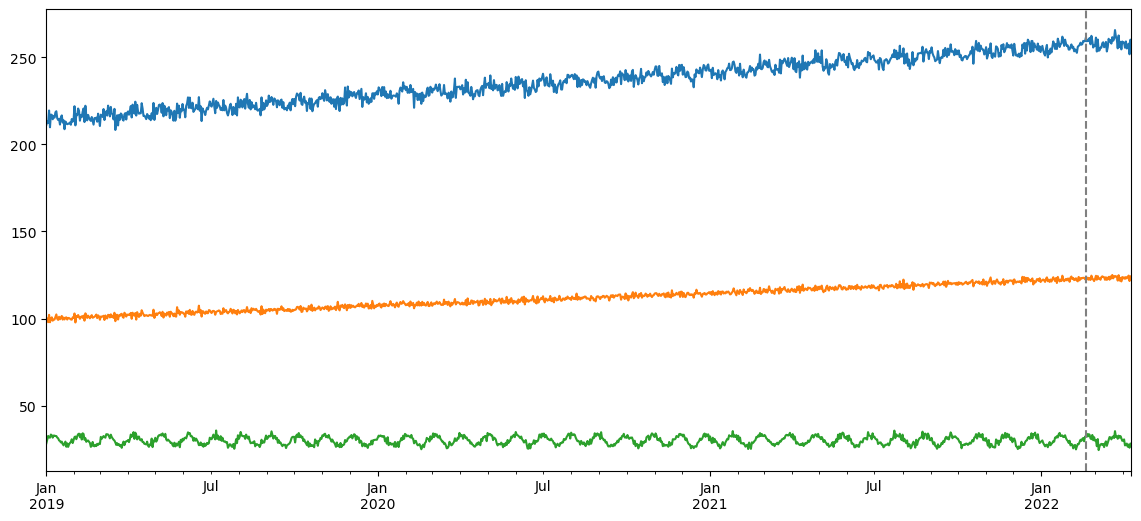

In [36]:
# создадим датасет
np.random.seed(2)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

trend_x0 = np.arange(0, 8, 8/1196) #добавим тренд
trend_y = np.arange(0, 15, 15/1196)

# Синусоида для повтора цикла каждые 30 дней, еженедельная сезонность
seasonal_component_monthly = np.sin(2 * np.pi * np.arange(1196) / 30)

# Синусоида для повтора цикла каждые 180 дней, еженедельная сезонность
#seasonal_component_monthly = np.sin(2 * np.pi * np.arange(1196) / 240)*2

x0 = 100 + arma_process.generate_sample(nsample=1196) + trend_x0*3
x1 = 30 + arma_process.generate_sample(nsample=1196) + seasonal_component_monthly*3
y = 1.9 * x0 + 0.8* x1 + np.random.normal(size=1196) #+ trend_y# + seasonal_component_monthly
data = pd.DataFrame({'x0': x0, 'y': y}, columns=['y', 'x0'])
data = pd.DataFrame({'x0': x0, 'y': y, 'x1': x1}, columns=['y', 'x0', 'x1'])

date_range = pd.date_range(start="2019-01-01", periods=1196)
ts_data_2 = data.copy()
ts_data_2.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2019-01-01", "2022-02-19"]]
ts_post_period = [pd.to_datetime(date) for date in ["2022-02-20", "2022-04-10"]]

#ts_data.loc[ts_post_period[0]:ts_post_period[-1], 'y'] *= 1.03 # добавим эффект

plt.figure(figsize = (14, 6))
ts_data_2.y.plot(label = 'y')
ts_data_2.x0.plot(label = 'x0')
ts_data_2.x1.plot(label = 'x1')
plt.axvline(x= '2022-02-19',  color = 'grey', ls = '--')

In [37]:
ts_data_2.head()

y          x0         x1
2019-01-01  211.314401   99.583242  28.364594
2019-01-02  213.157618  100.047152  30.422463
2019-01-03  212.397861   97.898521  32.581431
2019-01-04  219.497744  102.128794  31.759123
2019-01-05  209.852248   97.873113  31.574474

In [38]:
ts_pre_period

[Timestamp('2019-01-01 00:00:00'), Timestamp('2022-02-19 00:00:00')]

In [39]:
ci_2 = CausalImpact(ts_data_2, ts_pre_period, ts_post_period)

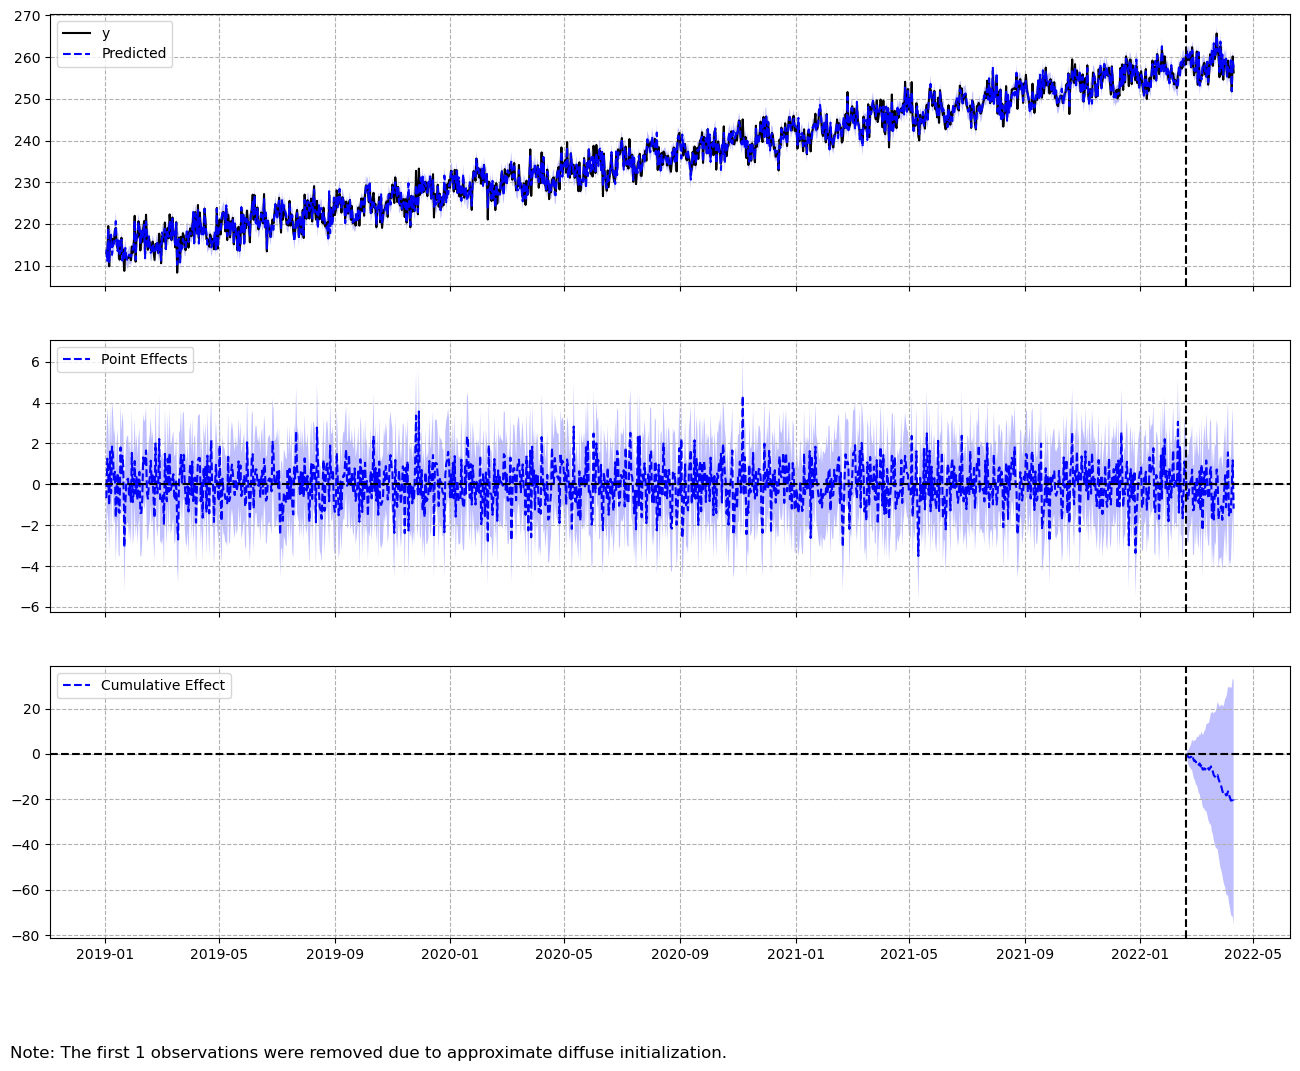

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    258.03             12901.46
Prediction (s.d.)         258.44 (0.55)      12922.09 (27.66)
95% CI                    [257.38, 259.55]   [12868.88, 12977.32]

Absolute effect (s.d.)    -0.41 (0.55)       -20.63 (27.66)
95% CI                    [-1.52, 0.65]      [-75.86, 32.58]

Relative effect (s.d.)    -0.16% (0.21%)     -0.16% (0.21%)
95% CI                    [-0.59%, 0.25%]    [-0.59%, 0.25%]

Posterior tail-area probability p: 0.23
Posterior prob. of a causal effect: 77.42%

For more details run the command: print(impact.summary('report'))


In [40]:
ci_2.plot(figsize = (16, 12))
print(ci_2.summary())

In [41]:
ci_2.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                 1146
Model:                    local level   Log Likelihood                1219.161
Date:                Mon, 23 Oct 2023   AIC                          -2430.321
Time:                        16:59:00   BIC                          -2410.149
Sample:                    01-01-2019   HQIC                         -2422.705
                         - 02-19-2022                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0064      0.000     23.296      0.000       0.006       0.007
sigma2.level      6.944e-05   2.77e-05      2.506      0.012    1.51e-05       0.000
beta.x0              0.9878      0.016     63.591      0.000       0.957       1.018
beta.x1              0.1447      0.003     55.094      0.000       0.140       0.150
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.42   Prob(JB):                         0.45
Heteroskedasticity (H):               1.07   Skew:                            -0.02
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p-value тест Дики-Фуллера = 0.000000
p-value тест Стьюдента = 0.851139
p-value тест Льюнга-Бокса = 0.422082


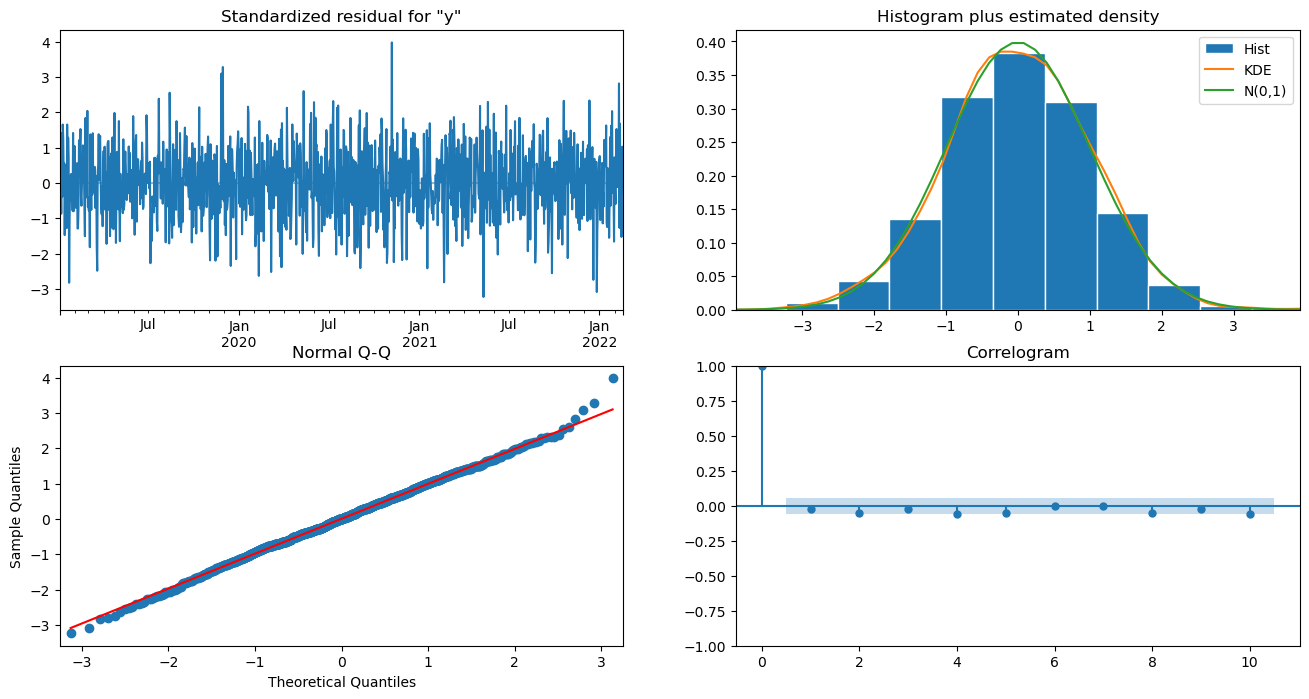

In [42]:
# давайте отпринтуем результаты проверки остатков модели
print("p-value тест Дики-Фуллера = %f" % sm.tsa.stattools.adfuller(ci_2.trained_model.resid)[1])
print("p-value тест Стьюдента = %f" % ttest_1samp(ci_2.trained_model.resid, 0)[1])
print("p-value тест Льюнга-Бокса = %f" % ci_2.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci_2.trained_model.plot_diagnostics(figsize = (16, 8));

### 3.3.2. Прогоним через код с перебором коварат и оценим ошибки 1 и 2 рода для "хороших" данных

In [43]:
# создадим комбинации ковариат для перебора в ts_data
column_combinations = []
for i in range(1, len(ts_data_2.columns[1:]) + 1):
    column_combinations.extend(list(combinations(ts_data_2.columns[1:], i)))
column_combinations

[('x0',), ('x1',), ('x0', 'x1')]

In [44]:
%%time
n_sim = 100
res = pd.DataFrame()
for comb in column_combinations:
    caus = causal_analysis(ts_data_2, 'y', comb, 14, 0.7, n_sim)
    res = pd.concat([res, caus], axis = 0)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  3.6min
[Paralle

[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  87 out of 100 | elapsed: 44.1min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done  89 out of 100 | elapsed: 44.4min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed: 44.4min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed: 44.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 44.6min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed: 44.9min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 44.9min finished
CPU times

post_period_0 post_period_1 pre_period_0 pre_period_1       sse      mape  \
0     2022-03-05    2022-03-18   2019-01-01   2022-03-04  0.000291  0.642857   
1     2021-07-24    2021-08-06   2019-01-01   2021-07-23  0.000157  0.471429   
2     2021-12-03    2021-12-16   2019-01-01   2021-12-02  0.000516  0.857143   
3     2021-05-04    2021-05-17   2019-01-01   2021-05-03  0.000588  0.914286   
4     2021-07-09    2021-07-22   2019-01-01   2021-07-08  0.000166  0.485714   
..           ...           ...          ...          ...       ...       ...   
95    2022-02-14    2022-02-27   2019-01-01   2022-02-13  0.000007  0.100000   
96    2021-05-03    2021-05-16   2019-01-01   2021-05-02  0.000028  0.200000   
97    2021-08-28    2021-09-10   2019-01-01   2021-08-27  0.000028  0.200000   
98    2021-08-04    2021-08-17   2019-01-01   2021-08-03  0.000007  0.100000   
99    2021-07-12    2021-07-25   2019-01-01   2021-07-11  0.000028  0.200000   

     p_val_1  p_val_1_025  p_val_0_975  p_val_1_05  p_val_0_95  p_val_1_1  \
0   0.026973          0.0          0.0         0.0         0.0        0.0   
1   0.068931          0.0          0.0         0.0         0.0        0.0   
2   0.002997          0.0          0.0         0.0         0.0        0.0   
3   0.002997          0.0          0.0         0.0         0.0        0.0   
4   0.053946          0.0          0.0         0.0         0.0        0.0   
..       ...          ...          ...         ...         ...        ...   
95  0.245754          0.0          0.0         0.0         0.0        0.0   
96  0.106893          0.0          0.0         0.0         0.0        0.0   
97  0.135864          0.0          0.0         0.0         0.0        0.0   
98  0.379620          0.0          0.0         0.0         0.0        0.0   
99  0.124875          0.0          0.0         0.0         0.0        0.0   

    p_val_0_9 covariate  
0         0.0        x0  
1         0.0        x0  
2         0.0        x0  
3         0.0        x0  
4         0.0        x0  
..        ...       ...  
95        0.0    x0, x1  
96        0.0    x0, x1  
97        0.0    x0, x1  
98        0.0    x0, x1  
99        0.0    x0, x1  

[300 rows x 14 columns]

На выходе получаем датафрейм кросс-валидацию, где каждая строчка это отдельно примененный Causal Impact на искусственно заданных эффектах

In [45]:
# создадим функцию, которая аггрегирует результаты по каждому набору ковариат
def to_res(data, to_group, n, alpha = 0.05):
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha)

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha)
    
    p_val_cols = data.filter(like = 'p_val').columns
    
    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum',
                                     'mape': 'mean',
                                     p_val_cols[0]: p_val_count_alpha,
                                     p_val_cols[1]: p_val_count_beta,
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})
    
    res[p_val_cols[0]] = res[p_val_cols[0]] / n
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n
    
    return res

In [46]:
res_conc = to_res(res, 'covariate', n_sim)
res_conc

sse      mape  p_val_1  p_val_1_025  p_val_0_975  p_val_1_05  \
covariate                                                                      
x0         0.030651  0.597286     0.62          0.0          0.0         0.0   
x0, x1     0.001435  0.113286     0.02          0.0          0.0         0.0   
x1         0.010761  0.335286     0.12          0.0          0.0         0.0   

           p_val_0_95  p_val_1_1  p_val_0_9    pre_period_diff  
covariate                                                       
x0                0.0        0.0        0.0 1002 days 11:31:12  
x0, x1            0.0        0.0        0.0 1002 days 11:31:12  
x1                0.0        0.0        0.0 1002 days 11:31:12

Видим, что на "хороших" данных модель чувствует себя "молодцом" почти совсем нет ошибок второго рода. При этом по ковариате x0 встречаются ошибке первого рода. Но как только мы подключаем x1 проблема исправляется. Коварата x1 явно полезна модели.

## 3.4. Прогоним методику симуляции на "реальных" ("плохих") данных

### 3.4.1. Прогоним CI разово на плохих данных

In [47]:
spares_data.head( )

cnt_adverts_spare  cnt_users_spare  revenue_spare  \
date                                                            
2020-02-02             211754             8650        1488315   
2020-02-03             212954             8728        2409055   
2020-02-04             210585             8697        2369018   
2020-02-05             209464             8718        3368615   
2020-02-06             207544             8738        2123040   

            cnt_adverts_cars  cnt_users_cars  revenue_cars  holidays  \
date                                                                   
2020-02-02            208126          127603       6715565         0   
2020-02-03            212119          129672       7659757         0   
2020-02-04            209994          129373       7647455         0   
2020-02-05            209486          129736       7654975         0   
2020-02-06            209644          129867       7877610         0   

            new_users_share_spare  new_users_share_auto  
date                                                     
2020-02-02                 0.1183               0.15925  
2020-02-03                 0.1313               0.17675  
2020-02-04                 0.1339               0.18025  
2020-02-05                 0.1196               0.16100  
2020-02-06                 0.1248               0.16800

In [48]:
# для симуляции нужны данные без эффекта давайте отсечем период, когда было воздействие
spares_data_AA = spares_data[spares_data.index < '2020-04-25']

#### давайте разово прогоним CI на этих данных, чтобы лучше понимать что нас ждет

In [49]:
data_3 = spares_data_AA.loc[:,['cnt_users_spare', 'cnt_users_cars', 'cnt_adverts_cars', 'new_users_share_auto', 'revenue_cars']]
pre_period = ['2020-02-02', '2020-04-14'] 
post_period = ['2020-04-15', '2020-04-24']
ci_3 = CausalImpact(data_3, pre_period, post_period)

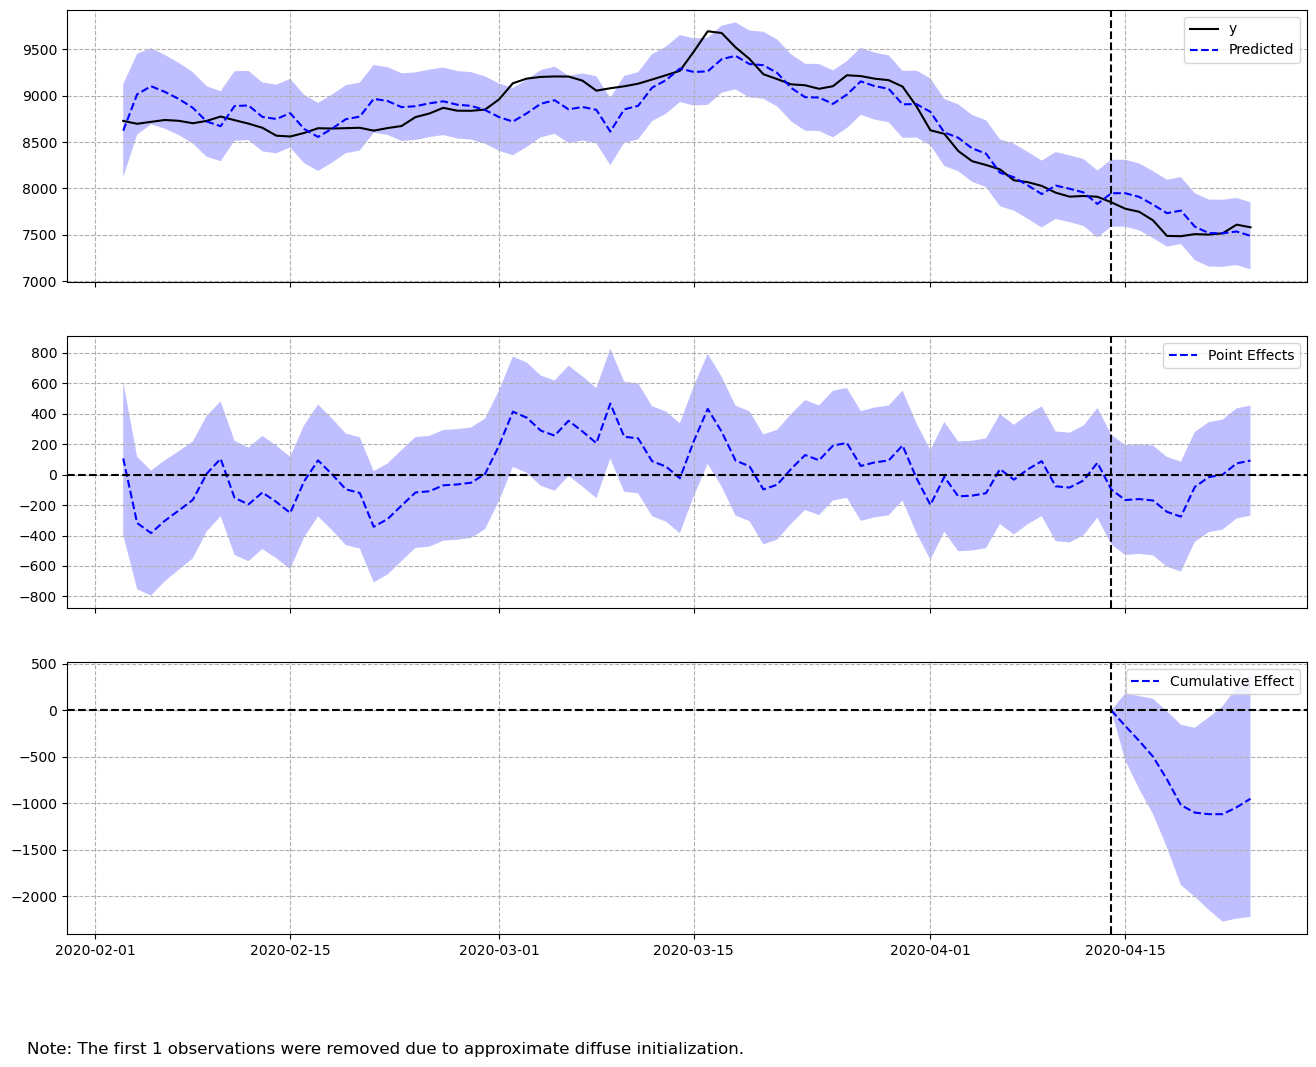

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    7588.2             75882.0
Prediction (s.d.)         7683.14 (66.46)    76831.45 (664.55)
95% CI                    [7549.71, 7810.21] [75497.08, 78102.08]

Absolute effect (s.d.)    -94.94 (66.46)     -949.45 (664.55)
95% CI                    [-222.01, 38.49]   [-2220.08, 384.92]

Relative effect (s.d.)    -1.24% (0.86%)     -1.24% (0.86%)
95% CI                    [-2.89%, 0.5%]     [-2.89%, 0.5%]

Posterior tail-area probability p: 0.09
Posterior prob. of a causal effect: 91.21%

For more details run the command: print(impact.summary('report'))


In [50]:
ci_3.plot(figsize = (16, 12))
print(ci_3.summary())

In [51]:
ci_3.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:        cnt_users_spare   No. Observations:                   73
Model:                    local level   Log Likelihood                 -44.485
Date:                Mon, 23 Oct 2023   AIC                            100.971
Time:                        17:58:31   BIC                            114.631
Sample:                    02-02-2020   HQIC                           106.409
                         - 04-14-2020                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
sigma2.irregular              0.1807      0.042      4.316      0.000       0.099       0.263
sigma2.level                  0.0001      0.000      0.311      0.756      -0.001       0.001
beta.cnt_users_cars          17.0394      1.871      9.106      0.000      13.372      20.707
beta.cnt_adverts_cars       -16.6517      1.899     -8.767      0.000     -20.374     -12.929
beta.new_users_share_auto     0.1102      0.116      0.951      0.342      -0.117       0.338
beta.revenue_cars             0.1522      0.173      0.882      0.378      -0.186       0.490
===================================================================================
Ljung-Box (L1) (Q):                  44.46   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.00   Prob(JB):                         0.39
Heteroskedasticity (H):               0.37   Skew:                             0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.4.2. Переберем ковариаты на "плохих данных

In [52]:
# для иллюстрации возьмем лишь несколько ковариат
spares_data_for_comb = spares_data[['cnt_users_cars', 'cnt_adverts_cars', 'revenue_cars']]

In [53]:
# создадим комбинации ковариат для перебора
column_combinations = []
for i in range(1, len(spares_data_for_comb.columns) + 1):
    column_combinations.extend(list(combinations(spares_data_for_comb.columns, i)))
column_combinations

[('cnt_users_cars',),
 ('cnt_adverts_cars',),
 ('revenue_cars',),
 ('cnt_users_cars', 'cnt_adverts_cars'),
 ('cnt_users_cars', 'revenue_cars'),
 ('cnt_adverts_cars', 'revenue_cars'),
 ('cnt_users_cars', 'cnt_adverts_cars', 'revenue_cars')]

In [54]:
data_3.head()

cnt_users_spare  cnt_users_cars  cnt_adverts_cars  \
date                                                            
2020-02-02             8650          127603            208126   
2020-02-03             8728          129672            212119   
2020-02-04             8697          129373            209994   
2020-02-05             8718          129736            209486   
2020-02-06             8738          129867            209644   

            new_users_share_auto  revenue_cars  
date                                            
2020-02-02               0.15925       6715565  
2020-02-03               0.17675       7659757  
2020-02-04               0.18025       7647455  
2020-02-05               0.16100       7654975  
2020-02-06               0.16800       7877610

На выходе получаем датафрейм кросс-валидацию, где каждая строчка это отдельно примененный Causal Impact на искусственно заданных эффектах

In [55]:
%%time
n_sim = 50
res = pd.DataFrame()
for comb in column_combinations:
    caus = causal_analysis(data_3, 'cnt_users_spare', comb, 10, 0.7, n_sim)
    res = pd.concat([res, caus], axis = 0)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.0min remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 

[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 85.1min remaining: 13.9min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 85.3min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 85.3min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 85.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed

post_period_0 post_period_1 pre_period_0 pre_period_1       sse       mape  \
0     2020-04-14    2020-04-23   2020-02-02   2020-04-13  0.041810   7.714286   
1     2020-04-13    2020-04-22   2020-02-02   2020-04-12  0.042756   7.800000   
2     2020-04-14    2020-04-23   2020-02-02   2020-04-13  0.041810   7.714286   
3     2020-04-02    2020-04-11   2020-02-02   2020-04-01  0.104566  12.200000   
4     2020-04-12    2020-04-21   2020-02-02   2020-04-11  0.042756   7.800000   
..           ...           ...          ...          ...       ...        ...   
45    2020-04-03    2020-04-12   2020-02-02   2020-04-02  0.005624   2.828571   
46    2020-04-12    2020-04-21   2020-02-02   2020-04-11  0.000403   0.757143   
47    2020-04-12    2020-04-21   2020-02-02   2020-04-11  0.000403   0.757143   
48    2020-04-04    2020-04-13   2020-02-02   2020-04-03  0.001407   1.414286   
49    2020-04-06    2020-04-15   2020-02-02   2020-04-05  0.000022   0.171429   

     p_val_1  p_val_1_025  p_val_0_975  p_val_1_05  p_val_0_95  p_val_1_1  \
0   0.000000     0.000000     0.000000    0.005994         0.0   0.134865   
1   0.000000     0.000000     0.000000    0.008991         0.0   0.151848   
2   0.000000     0.000000     0.000000    0.014985         0.0   0.144855   
3   0.000000     0.000000     0.000000    0.000000         0.0   0.001998   
4   0.000000     0.000000     0.000000    0.008991         0.0   0.169830   
..       ...          ...          ...         ...         ...        ...   
45  0.001998     0.294705     0.000000    0.005994         0.0   0.000000   
46  0.211788     0.025974     0.000000    0.000000         0.0   0.000000   
47  0.184815     0.022977     0.000000    0.000000         0.0   0.000000   
48  0.041958     0.117882     0.000000    0.000000         0.0   0.000000   
49  0.416583     0.000999     0.004995    0.000000         0.0   0.000000   

    p_val_0_9                                       covariate  
0         0.0                                  cnt_users_cars  
1         0.0                                  cnt_users_cars  
2         0.0                                  cnt_users_cars  
3         0.0                                  cnt_users_cars  
4         0.0                                  cnt_users_cars  
..        ...                                             ...  
45        0.0  cnt_users_cars, cnt_adverts_cars, revenue_cars  
46        0.0  cnt_users_cars, cnt_adverts_cars, revenue_cars  
47        0.0  cnt_users_cars, cnt_adverts_cars, revenue_cars  
48        0.0  cnt_users_cars, cnt_adverts_cars, revenue_cars  
49        0.0  cnt_users_cars, cnt_adverts_cars, revenue_cars  

[350 rows x 14 columns]

На выходе получаем датафрейм кросс-валидацию, где каждая строчка это отдельно примененный Causal Impact на искусственно заданных эффектах

In [56]:
def to_res(data, to_group, n, alpha = 0.05):
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha)

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha)
    
    p_val_cols = data.filter(like = 'p_val').columns
    
    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum',
                                     'mape': 'mean',
                                     p_val_cols[0]: p_val_count_alpha,
                                     p_val_cols[1]: p_val_count_beta,
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})
    
    res[p_val_cols[0]] = res[p_val_cols[0]] / n
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n
    
    return res

In [63]:
res_conc = to_res(res, 'covariate', n_sim)
res_conc

sse       mape  p_val_1  \
covariate                                                                      
cnt_adverts_cars                                3.779958  10.217714     1.00   
cnt_adverts_cars, revenue_cars                  3.605903   9.823714     1.00   
cnt_users_cars                                  3.552123   9.859143     1.00   
cnt_users_cars, cnt_adverts_cars                0.189491   1.648857     0.36   
cnt_users_cars, cnt_adverts_cars, revenue_cars  0.258752   1.938857     0.40   
cnt_users_cars, revenue_cars                    3.107751   8.993429     1.00   
revenue_cars                                    3.803051  10.401429     1.00   

                                                p_val_1_025  p_val_0_975  \
covariate                                                                  
cnt_adverts_cars                                       0.00          0.0   
cnt_adverts_cars, revenue_cars                         0.00          0.0   
cnt_users_cars                                         0.00          0.0   
cnt_users_cars, cnt_adverts_cars                       0.16          0.0   
cnt_users_cars, cnt_adverts_cars, revenue_cars         0.28          0.0   
cnt_users_cars, revenue_cars                           0.00          0.0   
revenue_cars                                           0.00          0.0   

                                                p_val_1_05  p_val_0_95  \
covariate                                                                
cnt_adverts_cars                                      0.00         0.0   
cnt_adverts_cars, revenue_cars                        0.00         0.0   
cnt_users_cars                                        0.00         0.0   
cnt_users_cars, cnt_adverts_cars                      0.20         0.0   
cnt_users_cars, cnt_adverts_cars, revenue_cars        0.28         0.0   
cnt_users_cars, revenue_cars                          0.42         0.0   
revenue_cars                                          0.00         0.0   

                                                p_val_1_1  p_val_0_9  \
covariate                                                              
cnt_adverts_cars                                     0.54        0.0   
cnt_adverts_cars, revenue_cars                       0.44        0.0   
cnt_users_cars                                       0.54        0.0   
cnt_users_cars, cnt_adverts_cars                     0.00        0.0   
cnt_users_cars, cnt_adverts_cars, revenue_cars       0.00        0.0   
cnt_users_cars, revenue_cars                         0.22        0.0   
revenue_cars                                         0.74        0.0   

                                                pre_period_diff  
covariate                                                        
cnt_adverts_cars                               63 days 18:14:24  
cnt_adverts_cars, revenue_cars                 63 days 18:14:24  
cnt_users_cars                                 63 days 18:14:24  
cnt_users_cars, cnt_adverts_cars               63 days 18:14:24  
cnt_users_cars, cnt_adverts_cars, revenue_cars 63 days 18:14:24  
cnt_users_cars, revenue_cars                   63 days 18:14:24  
revenue_cars                                   63 days 18:14:24

Для каждой ковариаты, получаем метрики ошибок sse, mape, а так же alpha значение и beta значения для заданных эффектов. Сортируя этот датафрейм, можем отобрать наилучшую комбинацию ковариат

# 4. Выбор количества дней, сколько дней нужно ждать чтобы замерить тот или иной эффект. Подбор длительности causal_impact

## 4.1. Создадим функцию для поиска кол-ва дней

In [66]:
import joblib

def causal_analysis_period(data, target_value, covariate, n_days =14, control_percent = 0.6, sample_n = 30):
    
    '''
    data - исторические данные на которых мы оцениваем ковариату
    target_value - название нашей целевой метрики
    covariate - назвние столбца ковариат
    n_days - период в днях на post период
    control_percent - доля датасета зарезервированного под pre период (0.1)
    sample_n - кол-во симуляций
    '''
    
    if n_days > 1:
        n_days -= 1
    
    data = pd.concat([data.loc[:, [target_value]], data.loc[:, covariate]], axis = 1)
    
    df_copy = data.copy()
    effects = [1.0, 1.03, 1.05, 1.07, 1.09, 1.1, 1.13, 1.15] # Эффекты
    rel_effects = []

    dates = pd.DataFrame({'post_period_0': data.index}) # Даты

    # Самая первая дата контрольной группы
    initial = dates.values[0][0]
    # Тестовая группа, подбираем из неё 10 рандомных дат
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\
    # Определяем пост и пре период
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            df_copy = data.copy() # создаём другую переменную дубликата датафрейма чтобы каждый раз задавать новый эффект

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), target_value] *= effects[i] # задаём эффект
            ci = CausalImpact(df_copy, pre_period, post_period)

            relative_eff = ci.summary_data.loc['rel_effect', :][0].round(3)
            real_eff = effects[i] - 1
            to_sse = pow(relative_eff - real_eff, 2)
            to_mape = abs(relative_eff - real_eff) * 100

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(relative_eff)
            p_vals.append(ci.p_value)
        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1.0)], p_vals[effects.index(1.03)], 
               p_vals[effects.index(1.05)], p_vals[effects.index(1.07)], p_vals[effects.index(1.09)],
               p_vals[effects.index(1.1)], p_vals[effects.index(1.15)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))
    
    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]
        
    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_03', 'p_val_1_05', 'p_val_1_07',
                                    'p_val_1_09', 'p_val_1_1', 'p_val_1_13', 'p_val_1_15'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['n_day'] = n_day
    return final


In [68]:
ts_data_2

y          x0         x1
2019-01-01  211.314401   99.583242  28.364594
2019-01-02  213.157618  100.047152  30.422463
2019-01-03  212.397861   97.898521  32.581431
2019-01-04  219.497744  102.128794  31.759123
2019-01-05  209.852248   97.873113  31.574474
...                ...         ...        ...
2022-04-06  255.456645  123.778144  26.394909
2022-04-07  257.881070  124.672274  27.642136
2022-04-08  251.788882  121.533352  25.807701
2022-04-09  260.173859  124.300527  28.211417
2022-04-10  256.353148  123.665713  27.893778

[1196 rows x 3 columns]

## 4.2. Пример с хорошими данными

In [69]:
%%time
n_sim = 30
res_m = pd.DataFrame()
for n_day in range(10, 21, 1):
    caus_m = causal_analysis_period(ts_data_2, 'y', ('x0', 'x1'), n_day, 0.7, n_sim)
    res_m = pd.concat([res_m, caus_m], axis = 0)
res_m

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  2.2min remaining:   55.7s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  2.3min remaining:   42.0s
[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed:  2

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  2.1min remaining:   55.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  2.3min remaining:   41.6s
[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed:  2.6min remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.6min remaining:   17.6s


CPU times: total: 1.67 s
Wall time: 28min 58s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


post_period_0 post_period_1 pre_period_0 pre_period_1           sse  \
0     2022-03-05    2022-03-14   2019-01-01   2022-03-04  8.000000e-06   
1     2021-07-24    2021-08-02   2019-01-01   2021-07-23  8.000000e-06   
2     2021-12-03    2021-12-12   2019-01-01   2021-12-02  3.200000e-05   
3     2021-05-04    2021-05-13   2019-01-01   2021-05-03  3.200000e-05   
4     2021-07-09    2021-07-18   2019-01-01   2021-07-08  3.200000e-05   
..           ...           ...          ...          ...           ...   
25    2022-02-22    2022-03-13   2019-01-01   2022-02-21  3.871119e-32   
26    2021-04-19    2021-05-08   2019-01-01   2021-04-18  8.000000e-06   
27    2021-05-26    2021-06-14   2019-01-01   2021-05-25  3.200000e-05   
28    2022-03-05    2022-03-24   2019-01-01   2022-03-04  3.871119e-32   
29    2021-07-10    2021-07-29   2019-01-01   2021-07-09  8.000000e-06   

            mape   p_val_1  p_val_1_03  p_val_1_05  p_val_1_07  p_val_1_09  \
0   1.000000e-01  0.368631         0.0         0.0         0.0         0.0   
1   1.000000e-01  0.280719         0.0         0.0         0.0         0.0   
2   2.000000e-01  0.185814         0.0         0.0         0.0         0.0   
3   2.000000e-01  0.211788         0.0         0.0         0.0         0.0   
4   2.000000e-01  0.198801         0.0         0.0         0.0         0.0   
..           ...       ...         ...         ...         ...         ...   
25  6.071532e-15  0.415584         0.0         0.0         0.0         0.0   
26  1.000000e-01  0.390609         0.0         0.0         0.0         0.0   
27  2.000000e-01  0.170829         0.0         0.0         0.0         0.0   
28  6.071532e-15  0.441558         0.0         0.0         0.0         0.0   
29  1.000000e-01  0.349650         0.0         0.0         0.0         0.0   

    p_val_1_1  p_val_1_13     p_val_1_15  n_day  
0         0.0         0.0   0.000000e+00     10  
1         0.0         0.0  5.434722e-323     10  
2         0.0         0.0  1.470723e-311     10  
3         0.0         0.0  1.471525e-311     10  
4         0.0         0.0   0.000000e+00     10  
..        ...         ...            ...    ...  
25        0.0         0.0   0.000000e+00     20  
26        0.0         0.0   0.000000e+00     20  
27        0.0         0.0   0.000000e+00     20  
28        0.0         0.0   0.000000e+00     20  
29        0.0         0.0   7.966080e+16     20  

[330 rows x 15 columns]

In [70]:
res_conc_m = to_res(res_m, 'n_day', n_sim)
#res_conc_m = res_conc_m.sort_values(by = list(res_conc_m.columns[:-1]))
res_conc_m

sse      mape  p_val_1  p_val_1_03  p_val_1_05  p_val_1_07  \
n_day                                                                    
10     0.000458  0.111667     0.02         0.0         0.0         0.0   
11     0.000361  0.085417     0.00         0.0         0.0         0.0   
12     0.000370  0.095833     0.00         0.0         0.0         0.0   
13     0.000332  0.082500     0.00         0.0         0.0         0.0   
14     0.000322  0.080833     0.00         0.0         0.0         0.0   
15     0.000379  0.090417     0.00         0.0         0.0         0.0   
16     0.000377  0.094583     0.00         0.0         0.0         0.0   
17     0.000339  0.087917     0.00         0.0         0.0         0.0   
18     0.000325  0.088750     0.00         0.0         0.0         0.0   
19     0.000264  0.069167     0.00         0.0         0.0         0.0   
20     0.000227  0.067083     0.00         0.0         0.0         0.0   

       p_val_1_09  p_val_1_1  p_val_1_13   pre_period_diff  
n_day                                                       
10            0.0        0.0         0.0 999 days 19:12:00  
11            0.0        0.0         0.0 999 days 19:12:00  
12            0.0        0.0         0.0 999 days 19:12:00  
13            0.0        0.0         0.0 999 days 19:12:00  
14            0.0        0.0         0.0 999 days 19:12:00  
15            0.0        0.0         0.0 999 days 19:12:00  
16            0.0        0.0         0.0 999 days 19:12:00  
17            0.0        0.0         0.0 999 days 19:12:00  
18            0.0        0.0         0.0 999 days 19:12:00  
19            0.0        0.0         0.0 999 days 19:12:00  
20            0.0        0.0         0.0 991 days 06:24:00

На выходе получаем очень схожее что было до этого, только теперь вместо ковариат у нас есть параметр n_day, т.е. кол-во дней после которого мы замеряем тот или иной заданный эффект. Так же можем наблюдать за средним кол-вом данных которые брались как тренировочные данные.
Как видно из таблицы начиная с 14 дней ошибки в данных очень не большие

## 4.3. Пример с плохими данными

In [527]:
data_3

cnt_users_spare  cnt_users_cars  cnt_adverts_cars  \
date                                                            
2020-02-02             8650          127603            208126   
2020-02-03             8728          129672            212119   
2020-02-04             8697          129373            209994   
2020-02-05             8718          129736            209486   
2020-02-06             8738          129867            209644   
...                     ...             ...               ...   
2020-04-20             7508           64501            103161   
2020-04-21             7503           64412            103296   
2020-04-22             7517           64701            103916   
2020-04-23             7610           64984            104351   
2020-04-24             7582           64048            102936   

            new_users_share_auto  revenue_cars  
date                                            
2020-02-02              0.159250       6715565  
2020-02-03              0.176750       7659757  
2020-02-04              0.180250       7647455  
2020-02-05              0.161000       7654975  
2020-02-06              0.168000       7877610  
...                          ...           ...  
2020-04-20              0.151506       2190702  
2020-04-21              0.149800       1969280  
2020-04-22              0.162094       1866002  
2020-04-23              0.167388       1782820  
2020-04-24              0.165681       1644670  

[83 rows x 5 columns]

In [535]:
%%time
n_sim = 20
res_m = pd.DataFrame()
for n_day in range(5, 15, 1):
    caus_m = causal_analysis_period(data_3, 'cnt_users_spare', ('cnt_users_cars', 'cnt_adverts_cars'), n_day, 0.7, n_sim)
    res_m = pd.concat([res_m, caus_m], axis = 0)
res_m

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:   57.0s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  1.7min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:  1.8min remaining:   58.0s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  1.8min remaining:   36.6s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.2min remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 c

[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  1.9min remaining:   36.9s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.3min remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:   53.6s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  1.6min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.7min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:  1.8min remaining:   56.8s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  1.

Wall time: 22min 32s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished


post_period_0 post_period_1 pre_period_0 pre_period_1       sse    mape  \
0     2020-04-13    2020-04-17   2020-02-02   2020-04-12  0.000191  0.4875   
1     2020-04-02    2020-04-06   2020-02-02   2020-04-01  0.008996  3.3500   
2     2020-04-02    2020-04-06   2020-02-02   2020-04-01  0.008996  3.3500   
3     2020-04-06    2020-04-10   2020-02-02   2020-04-05  0.000597  0.8625   
4     2020-04-17    2020-04-21   2020-02-02   2020-04-16  0.000580  0.8500   
..           ...           ...          ...          ...       ...     ...   
15    2020-04-09    2020-04-22   2020-02-02   2020-04-08  0.000029  0.1875   
16    2020-04-03    2020-04-16   2020-02-02   2020-04-02  0.004520  2.3750   
17    2020-04-04    2020-04-17   2020-02-02   2020-04-03  0.001229  1.2375   
18    2020-03-31    2020-04-13   2020-02-02   2020-03-30  0.023592  5.4250   
19    2020-03-31    2020-04-13   2020-02-02   2020-03-30  0.023592  5.4250   

     p_val_1  p_val_1_03  p_val_1_05  p_val_1_07  p_val_1_09  p_val_1_1  \
0   0.326673    0.014985    0.000000    0.000000         0.0        0.0   
1   0.003996    0.425574    0.051948    0.000000         0.0        0.0   
2   0.004995    0.456543    0.057942    0.000000         0.0        0.0   
3   0.215784    0.000999    0.000000    0.000000         0.0        0.0   
4   0.253746    0.026973    0.000000    0.000000         0.0        0.0   
..       ...         ...         ...         ...         ...        ...   
15  0.438561    0.000000    0.000000    0.000000         0.0        0.0   
16  0.000000    0.162837    0.000000    0.000000         0.0        0.0   
17  0.070929    0.011988    0.000000    0.000000         0.0        0.0   
18  0.000000    0.002997    0.336663    0.012987         0.0        0.0   
19  0.000000    0.000000    0.348651    0.009990         0.0        0.0   

    p_val_1_13     p_val_1_15  n_day  
0          0.0   1.657000e-03      5  
1          0.0   8.996000e-03      5  
2          0.0   1.437500e+00      5  
3          0.0   3.350000e+00      5  
4          0.0   1.268731e-01      5  
..         ...            ...    ...  
15         0.0   0.000000e+00     14  
16         0.0   0.000000e+00     14  
17         0.0   0.000000e+00     14  
18         0.0  1.494263e-311     14  
19         0.0  1.494266e-311     14  

[200 rows x 15 columns]

In [72]:
res_m

post_period_0 post_period_1 pre_period_0 pre_period_1           sse  \
0     2022-03-05    2022-03-14   2019-01-01   2022-03-04  8.000000e-06   
1     2021-07-24    2021-08-02   2019-01-01   2021-07-23  8.000000e-06   
2     2021-12-03    2021-12-12   2019-01-01   2021-12-02  3.200000e-05   
3     2021-05-04    2021-05-13   2019-01-01   2021-05-03  3.200000e-05   
4     2021-07-09    2021-07-18   2019-01-01   2021-07-08  3.200000e-05   
..           ...           ...          ...          ...           ...   
25    2022-02-22    2022-03-13   2019-01-01   2022-02-21  3.871119e-32   
26    2021-04-19    2021-05-08   2019-01-01   2021-04-18  8.000000e-06   
27    2021-05-26    2021-06-14   2019-01-01   2021-05-25  3.200000e-05   
28    2022-03-05    2022-03-24   2019-01-01   2022-03-04  3.871119e-32   
29    2021-07-10    2021-07-29   2019-01-01   2021-07-09  8.000000e-06   

            mape   p_val_1  p_val_1_03  p_val_1_05  p_val_1_07  p_val_1_09  \
0   1.000000e-01  0.368631         0.0         0.0         0.0         0.0   
1   1.000000e-01  0.280719         0.0         0.0         0.0         0.0   
2   2.000000e-01  0.185814         0.0         0.0         0.0         0.0   
3   2.000000e-01  0.211788         0.0         0.0         0.0         0.0   
4   2.000000e-01  0.198801         0.0         0.0         0.0         0.0   
..           ...       ...         ...         ...         ...         ...   
25  6.071532e-15  0.415584         0.0         0.0         0.0         0.0   
26  1.000000e-01  0.390609         0.0         0.0         0.0         0.0   
27  2.000000e-01  0.170829         0.0         0.0         0.0         0.0   
28  6.071532e-15  0.441558         0.0         0.0         0.0         0.0   
29  1.000000e-01  0.349650         0.0         0.0         0.0         0.0   

    p_val_1_1  p_val_1_13     p_val_1_15  n_day pre_period_diff  
0         0.0         0.0   0.000000e+00     10       1158 days  
1         0.0         0.0  5.434722e-323     10        934 days  
2         0.0         0.0  1.470723e-311     10       1066 days  
3         0.0         0.0  1.471525e-311     10        853 days  
4         0.0         0.0   0.000000e+00     10        919 days  
..        ...         ...            ...    ...             ...  
25        0.0         0.0   0.000000e+00     20       1147 days  
26        0.0         0.0   0.000000e+00     20        838 days  
27        0.0         0.0   0.000000e+00     20        875 days  
28        0.0         0.0   0.000000e+00     20       1158 days  
29        0.0         0.0   7.966080e+16     20        920 days  

[330 rows x 16 columns]

In [71]:
res_conc_m = to_res(res_m, 'n_day', n_sim)
#res_conc_m = res_conc_m.sort_values(by = list(res_conc_m.columns[:-1]))
res_conc_m

sse      mape  p_val_1  p_val_1_03  p_val_1_05  p_val_1_07  \
n_day                                                                    
10     0.000458  0.111667     0.02         0.0         0.0         0.0   
11     0.000361  0.085417     0.00         0.0         0.0         0.0   
12     0.000370  0.095833     0.00         0.0         0.0         0.0   
13     0.000332  0.082500     0.00         0.0         0.0         0.0   
14     0.000322  0.080833     0.00         0.0         0.0         0.0   
15     0.000379  0.090417     0.00         0.0         0.0         0.0   
16     0.000377  0.094583     0.00         0.0         0.0         0.0   
17     0.000339  0.087917     0.00         0.0         0.0         0.0   
18     0.000325  0.088750     0.00         0.0         0.0         0.0   
19     0.000264  0.069167     0.00         0.0         0.0         0.0   
20     0.000227  0.067083     0.00         0.0         0.0         0.0   

       p_val_1_09  p_val_1_1  p_val_1_13   pre_period_diff  
n_day                                                       
10            0.0        0.0         0.0 999 days 19:12:00  
11            0.0        0.0         0.0 999 days 19:12:00  
12            0.0        0.0         0.0 999 days 19:12:00  
13            0.0        0.0         0.0 999 days 19:12:00  
14            0.0        0.0         0.0 999 days 19:12:00  
15            0.0        0.0         0.0 999 days 19:12:00  
16            0.0        0.0         0.0 999 days 19:12:00  
17            0.0        0.0         0.0 999 days 19:12:00  
18            0.0        0.0         0.0 999 days 19:12:00  
19            0.0        0.0         0.0 999 days 19:12:00  
20            0.0        0.0         0.0 991 days 06:24:00